In [1]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
from PIL import Image
import timm
import torch
from tqdm import tqdm
import ast
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

/Users/veeranonthuvasin/Desktop/MSc-Data-Science-Bristol/Dissertation/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
writers_info = pd.read_csv('./Final-Data/new-writers-info.csv')

writers_info = writers_info.loc[(writers_info['NativeLanguage'] != 'Swiss German') & (writers_info['NativeLanguage'] != 'English')]

writers_info

,name,DayOfBirth,EducationalDegree,Gender,NativeCountry,NativeLanguage,OtherLanguage,Profession,WritingType,Science,WrittenLanguage,ascii_path,images_path,stroke_path
0,10000,1982-06-08,Dipl. Inform.,Male,Germany,German,French,PhD-Student,Right-handed,Mathematics,English,"['./Data/ascii/z01/z01-000/z01-000.txt', './Da...",['./Data/lineImages/z01/z01-000/z01-000-*.tif'...,['./Data/lineStrokes/z01/z01-000/z01-000-*.xml...
2,10004,NaN,NaN,Male,France,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a02/a02-082/a02-082.txt', './Da...",['./Data/lineImages/a02/a02-082/a02-082-*.tif'...,['./Data/lineStrokes/a02/a02-082/a02-082-*.xml...
3,10007,NaN,NaN,Male,France,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-014/a01-014.txt', './Da...",['./Data/lineImages/a01/a01-014/a01-014-*.tif'...,['./Data/lineStrokes/a01/a01-014/a01-014-*.xml...
4,10008,NaN,NaN,Male,France,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-077/a01-077.txt', './Da...",['./Data/lineImages/a01/a01-077/a01-077-*.tif'...,['./Data/lineStrokes/a01/a01-077/a01-077-*.xml...
5,10009,NaN,NaN,Male,Germany,German,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-003/a01-003.txt', './Da...",['./Data/lineImages/a01/a01-003/a01-003-*.tif'...,['./Data/lineStrokes/a01/a01-003/a01-003-*.xml...
6,10010,NaN,NaN,Male,Switzerland,French,English,NaN,Right-handed,NaN,French,"['./Data/ascii/a01/a01-117/a01-117.txt', './Da...",['./Data/lineImages/a01/a01-117/a01-117-*.tif'...,['./Data/lineStrokes/a01/a01-117/a01-117-*.xml...
7,10011,NaN,NaN,Male,Switzerland,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-000/a01-000u.txt', './D...",['./Data/lineImages/a01/a01-000/a01-000u-*.tif...,['./Data/lineStrokes/a01/a01-000/a01-000u-*.xm...
8,10012,NaN,NaN,Male,Switzerland,French,NaN,NaN,Right-handed,NaN,English,"['./Data/ascii/a01/a01-003/a01-003x.txt', './D...",['./Data/lineImages/a01/a01-003/a01-003x-*.tif...,['./Data/lineStrokes/a01/a01-003/a01-003x-*.xm...
9,10015,NaN,NaN,Female,Switzerland,French,English,NaN,Right-handed,NaN,French,"['./Data/ascii/a01/a01-020/a01-020.txt', './Da...",['./Data/lineImages/a01/a01-020/a01-020-*.tif'...,['./Data/lineStrokes/a01/a01-020/a01-020-*.xml...
10,10017,NaN,NaN,Male,Switzerland,French,English,NaN,Right-handed,NaN,French,"['./Data/ascii/a02/a02-000/a02-000.txt', './Da...",['./Data/lineImages/a02/a02-000/a02-000-*.tif'...,['./Data/lineStrokes/a02/a02-000/a02-000-*.xml...


In [3]:
writers_info['NativeLanguage'].value_counts()

NativeLanguage
German    19
French    16
Name: count, dtype: int64

# Utility Functions
- Feature Extraction Functions
- Change writer label

In [ ]:
def feature_extraction(writer_name, images_path):
  model = timm.create_model(
      'convnextv2_nano.fcmae_ft_in22k_in1k',
      pretrained=True,
      num_classes=0,  # remove classifier nn.Linear
  )
  model = model.eval()

  data_config = timm.data.resolve_model_data_config(model)
  transforms = timm.data.create_transform(**data_config, is_training=False)

  all_features_data = []
  writer_id_list = []
  writer_forms_list = []
  for name, i in tqdm(zip(writer_name,images_path)):
      i = ast.literal_eval(i)
      for j in i:
        j = j.replace('./', '../')
        image_list = glob.glob(j)
        for k in image_list:
          with Image.open(k) as img:
            img = img.convert('RGB')
            
            with torch.no_grad():
              output = model(transforms(img).unsqueeze(0))
            # print(output)
            # features = output.pooler_output.detach().numpy()
            # print(features)
            # last_hidden_states = outputs.last_hidden_state
            # print(last_hidden_states.shape)
            # features = last_hidden_states[:, 0, :]
            # print(features)
            # Store the results
            image_form = os.path.splitext(os.path.basename(k))[0]
            writer_forms_list.append(image_form)
            writer_id_list.append(name)
            all_features_data.append(output.detach().flatten().tolist())
                 

              


  writer_features_df = pd.DataFrame(data=all_features_data)
  writer_features_df['name'] = writer_id_list
  writer_features_df['form'] = writer_forms_list
  return writer_features_df

def convert_y(y):
  if y == 'German':
    return 0
  if y == 'French': 
    return 1

# Feature Extraction Full

In [ ]:
all_features = feature_extraction(writers_info['name'], writers_info['images_path'])
all_features

In [ ]:
all_features.to_csv('./Final-Data/German-French-IAM-X-y-Writer-Feature-Vectors.csv')

# Feature Extraction for Training Set (class-wise fixed images_per_subwrite sizes and bootstrapping, but dynamic sub_profile_per_writer)
- 4 Sentence-Level Images per Sub-writer Profile for English, creating 3 Sub-writer Profiles.
- 4 Sentence-Level Images per Sub-writer Profile for German/French, creating 12 Sub-writer Profiles.

In [ ]:
def create_sub_writers_bootstrap(train_df, feature_store, images_per_subwriter=4, fold_seed=42):
  
    writer_names_in_fold = train_df['name'].unique()
    feature_df = feature_store[feature_store['name'].isin(writer_names_in_fold)]

    feature_columns = [col for col in feature_df.columns if col not in ['name', 'form']]
    aggregated_data = []
    
    unique_writers = feature_df['name'].unique()
    
    for writer_id in unique_writers:
        writer_df = feature_df[feature_df['name'] == writer_id]
        num_images = len(writer_df)
        
        if num_images == 0:
            continue


        # try:
        #     language = train_df.loc[train_df['name'] == writer_id, 'NativeLanguage'].iloc[0]
        # except IndexError:
        #     print(f"Warning: Could not find language for writer_id {writer_id}. Skipping.")
        #     continue


        # if language == 'English':
        #     current_num_profiles_per_writer = 3  # Create fewer profiles for the low-data class
        # else:  # For German and French
        #     current_num_profiles_per_writer = 12 # Create more profiles for the high-data classes
        current_num_profiles_per_writer = 12


        if num_images <= images_per_subwriter:
            feature_chunk = writer_df[feature_columns]
            mean_features = feature_chunk.mean(axis=0)
            median_features = feature_chunk.median(axis=0)
            std_features = feature_chunk.std(axis=0).fillna(0)
            skew_features = feature_chunk.skew(axis=0).fillna(0)
            
            new_row = {}
            for col in feature_columns:
                new_row[f'{col}|mean'] = mean_features[col]
                new_row[f'{col}|median'] = median_features[col]
                new_row[f'{col}|std'] = std_features[col]
                new_row[f'{col}|skew'] = skew_features[col]
                
            new_row['original_writer_id'] = writer_id
            new_row['sub_writer_id'] = f"{writer_id}-agg-0"
            aggregated_data.append(new_row)
            continue

        writer_profiles = []
        max_attempts = current_num_profiles_per_writer * 5
        
        for i in range(max_attempts):

            sample_chunk = writer_df.sample(
                n=images_per_subwriter, 
                replace=True, 
                random_state=fold_seed + hash(writer_id) % 100000 + i
            )
            feature_chunk = sample_chunk[feature_columns]
            
            mean_features = feature_chunk.mean(axis=0)
            median_features = feature_chunk.median(axis=0)
            std_features = feature_chunk.std(axis=0).fillna(0)
            skew_features = feature_chunk.skew(axis=0).fillna(0)
            
            profile_dict = {}
            for col in feature_columns:
                profile_dict[f'{col}|mean'] = mean_features[col]
                profile_dict[f'{col}|median'] = median_features[col]
                profile_dict[f'{col}|std'] = std_features[col]
                profile_dict[f'{col}|skew'] = skew_features[col]
                
            writer_profiles.append(profile_dict)
            

            temp_df = pd.DataFrame(writer_profiles).drop_duplicates()
            if len(temp_df) >= current_num_profiles_per_writer:
                break
        
        if writer_profiles:
            profiles_df = pd.DataFrame(writer_profiles)
            unique_profiles_df = profiles_df.drop_duplicates().reset_index(drop=True)
            final_profiles_df = unique_profiles_df.head(current_num_profiles_per_writer)

            for i, row in final_profiles_df.iterrows():
                profile_data = row.to_dict()
                profile_data['original_writer_id'] = writer_id
                profile_data['sub_writer_id'] = f"{writer_id}-boot-{i}"
                aggregated_data.append(profile_data)
            
    final_df = pd.DataFrame(aggregated_data)
    
    if final_df.empty:
        return pd.DataFrame(), pd.Series(dtype='int')


    new_feature_columns = []
    for col in feature_columns:
        new_feature_columns.append(f'{col}|mean')
        new_feature_columns.append(f'{col}|median')
        new_feature_columns.append(f'{col}|std')
        new_feature_columns.append(f'{col}|skew')

    cols = ['sub_writer_id', 'original_writer_id'] + new_feature_columns
    final_df = final_df[cols]
    
    final_df = pd.merge(final_df, train_df[['name', 'NativeLanguage']], how='inner', left_on='original_writer_id', right_on='name')
    
    X_train = final_df.drop(columns=['sub_writer_id', 'original_writer_id','name','NativeLanguage'])
    y_train = final_df['NativeLanguage']
    y_train = np.vectorize(convert_y)(y_train)
    # display(X_train)
    return X_train, y_train

# Feature Extraction for Test set (Writer-Level Profile)

In [ ]:
def create_writer_level_profile(test_df, feature_store):
 
  writer_names_in_fold = test_df['name'].unique()
  test_features_df = feature_store[feature_store['name'].isin(writer_names_in_fold)]
  
  writer_level_feature_df = test_features_df.groupby(['name'], as_index=False)[test_features_df.columns[:-2]].agg(['mean', 'median', 'std', 'skew']).fillna(0)
  writer_level_feature_df.columns = writer_level_feature_df.columns.map(lambda x: '|'.join(map(str, x)))
  
  final_test_df = pd.merge(writer_level_feature_df, test_df[['name', 'NativeLanguage']], how='inner', left_on='name|', right_on='name')
  
  X_test = final_test_df.drop(columns=['name','name|','NativeLanguage'])
  y_test = final_test_df['NativeLanguage']
  y_test = np.vectorize(convert_y)(y_test)
  # display(X_test)
  
  return X_test, y_test
  
  

# Nested Cross-Validation

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
import optuna
from optuna.distributions import FloatDistribution, IntDistribution
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from imblearn.metrics import geometric_mean_score
import json
from collections import defaultdict


feature_store = pd.read_csv('./Final-Data/German-French-IAM-X-y-Writer-Feature-Vectors.csv', index_col=[0])
all_writers_info = feature_store[['name']].drop_duplicates().reset_index(drop=True)
all_writers_info = pd.merge(all_writers_info, writers_info[['name', 'NativeLanguage']], how='inner', on='name')
all_labels = all_writers_info['NativeLanguage']


outer_cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=42)
inner_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)

results_aggregator = {
    '0': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
    '1': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
    '2': {'precision': [], 'recall': [], 'f1-score': [], 'support': []},
    'accuracy': [],
    'g_mean': [],
    'confusion_matrices': []
}

outer_loop_scores = []
writer_level_results = defaultdict(lambda: {'true': [], 'predicted': []})
print("--- Starting Nested Cross-Validation ---")

# --- The Outer Loop ---
for i, (outer_train_idx, outer_test_idx) in enumerate(outer_cv.split(all_writers_info, all_labels)):
    outer_test_writers = all_writers_info.iloc[outer_test_idx]
    print("-" * 50)
    print(f"DEBUG: Writers in Outer Test Fold {i+1}: {sorted(outer_test_writers['name'].tolist())}")
    print("-" * 50)
    
    print(f"\nOuter Fold {i+1}/5")
    outer_train_writers, outer_train_labels = all_writers_info.iloc[outer_train_idx], all_labels.iloc[outer_train_idx]
    outer_test_writers, outer_test_labels = all_writers_info.iloc[outer_test_idx], all_labels.iloc[outer_test_idx]
    # display(outer_train_writers)
    # display(outer_train_labels)
    # print(outer_train_writers.shape)
    # print(outer_train_labels.shape)
    # print(outer_test_writers.shape)
    # --- The Inner Loop using Optuna ---
    def objective(trial):

        params = {
            'feature_selection__max_features': trial.suggest_int('feature_selection__max_features', 10, 1000),
            'classification__n_estimators': trial.suggest_int('classification__n_estimators', 50, 1000),
            'classification__learning_rate': trial.suggest_float('classification__learning_rate', 1e-3, 0.5, log=True),
            'classification__max_depth': trial.suggest_int('classification__max_depth', 3, 15),
            'classification__subsample': trial.suggest_float('classification__subsample', 0.6, 1.0),
            'classification__colsample_bytree': trial.suggest_float('classification__colsample_bytree', 0.6, 1.0),
            'classification__lambda': trial.suggest_float('classification__lambda', 0.1, 30.0, log=True),
            'classification__alpha': trial.suggest_float('classification__alpha', 0.1, 20.0, log=True),
            'classification__min_child_weight': trial.suggest_int('classification__min_child_weight', 1, 10)
        }

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
            ('classification', XGBClassifier(random_state=42, eval_metric='mlogloss'))
        ])
        pipeline.set_params(**params)

        # Perform inner cross-validation to evaluate this pipeline configuration
        inner_scores = []
        for j, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(outer_train_writers, outer_train_labels)):
            print(f"    - Trial #{trial.number}, Inner Fold {j+1}/{inner_cv.get_n_splits()}", end='\r')
            inner_train_writers = outer_train_writers.iloc[inner_train_idx]
            inner_val_writers = outer_train_writers.iloc[inner_val_idx]
            # display(inner_train_writers)

            X_inner_train, y_inner_train = create_sub_writers_bootstrap(inner_train_writers, feature_store, fold_seed=j)
            X_inner_val, y_inner_val = create_sub_writers_bootstrap(inner_val_writers, feature_store, fold_seed=j+1000)

            pipeline.fit(X_inner_train, y_inner_train)
            preds = pipeline.predict(X_inner_val)
            inner_scores.append(f1_score(y_inner_val, preds, average='macro'))
        
        # print(inner_scores)
        return np.mean(inner_scores)

    # Create and run the Optuna study to find the best params for this outer fold
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=15) 
    best_hyperparams = study.best_params
    print(f"  --- Optuna Complete. Best params for this fold: {best_hyperparams} ---")

    # --- Final Training and Evaluation for this Outer Fold ---
    
    X_train_fold, y_train_fold = create_sub_writers_bootstrap(outer_train_writers, feature_store, fold_seed=i)
    X_test_fold, y_test_fold = create_writer_level_profile(outer_test_writers, feature_store)
    
    print(f"\n--- DEBUG DATA FOR FOLD {i+1} ---")
    print(f"Shape of final X_train_fold: {X_train_fold.shape}")
    print(f"Shape of final X_test_fold: {X_test_fold.shape}")
    print(f"Sum of final X_test_fold values: {X_test_fold.to_numpy().sum()}") 
    print("---------------------------------\n")


    final_fold_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
        ('classification', XGBClassifier(random_state=42, eval_metric='mlogloss'))
    ])
    final_fold_pipeline.set_params(**best_hyperparams)
    

    final_fold_pipeline.fit(X_train_fold, y_train_fold)
    

    predictions = final_fold_pipeline.predict(X_test_fold)
    
    # --- Log the result for each writer in this test fold ---
    test_writer_ids = outer_test_writers['name'].tolist()
    
    for idx, writer_id in enumerate(test_writer_ids):
        true_label = y_test_fold[idx]
        predicted_label = predictions[idx]
        writer_level_results[writer_id]['true'].append(true_label)
        writer_level_results[writer_id]['predicted'].append(predicted_label)
        

    report = classification_report(y_test_fold, predictions, output_dict=True, zero_division=0)
    g_mean = geometric_mean_score(y_test_fold, predictions, average='macro')
    cm = confusion_matrix(y_test_fold, predictions, labels=[0, 1])
    
    for class_label in ['0', '1']:
        if class_label in report:
            for metric in ['precision', 'recall', 'f1-score', 'support']:
                results_aggregator[class_label][metric].append(report[class_label][metric])
    
    results_aggregator['accuracy'].append(report['accuracy'])
    results_aggregator['g_mean'].append(g_mean)
    results_aggregator['confusion_matrices'].append(cm.tolist())
    
    print(f"  --> Score for this fold (Macro F1): {report['macro avg']['f1-score']:.4f}, (G-Mean): {g_mean:.4f}, (Accuracy): {report['accuracy']}")

    # --- Save progress at the end of each fold ---
    print("  -> Saving progress to cv_results.json...")
    with open('German-French-IAM-cv_results_dynamic_subprofiles-12_fixed_img4_4fold-SMOTE.json', 'w') as f:
        json.dump(results_aggregator, f, indent=4)
    
    # score = f1_score(y_test_fold, predictions, average='macro')
    # outer_loop_scores.append(score)
    # print(f"  Score for Outer Fold {i+1}: {score:.4f}")
    


[I 2025-08-23 16:54:19,685] A new study created in memory with name: no-name-e6761040-f83d-468e-803f-f027b8ea15e1


--- Starting Nested Cross-Validation ---
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 1: [10000, 10010, 10015, 10032, 10052, 10089, 10109, 10164, 10219]
--------------------------------------------------

Outer Fold 1/5


[I 2025-08-23 16:55:57,949] Trial 0 finished with value: 0.6904662854815982 and parameters: {'feature_selection__max_features': 402, 'classification__n_estimators': 491, 'classification__learning_rate': 0.02258718140090614, 'classification__max_depth': 14, 'classification__subsample': 0.9472619468343654, 'classification__colsample_bytree': 0.7189454255801985, 'classification__lambda': 0.8155815183152204, 'classification__alpha': 2.3899324318598665, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.6904662854815982.


[I 2025-08-23 16:57:35,999] Trial 1 finished with value: 0.6959943865903617 and parameters: {'feature_selection__max_features': 938, 'classification__n_estimators': 984, 'classification__learning_rate': 0.0818836751675684, 'classification__max_depth': 8, 'classification__subsample': 0.9052559346539801, 'classification__colsample_bytree': 0.8160552501429745, 'classification__lambda': 2.8522430876591183, 'classification__alpha': 3.0161300986222614, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.6959943865903617.


[I 2025-08-23 16:59:11,093] Trial 2 finished with value: 0.7121521178069394 and parameters: {'feature_selection__max_features': 769, 'classification__n_estimators': 485, 'classification__learning_rate': 0.0044958982404336946, 'classification__max_depth': 11, 'classification__subsample': 0.8966426963292454, 'classification__colsample_bytree': 0.6774265523191827, 'classification__lambda': 0.8438363441787676, 'classification__alpha': 0.14040572363801224, 'classification__min_child_weight': 10}. Best is trial 2 with value: 0.7121521178069394.


[I 2025-08-23 17:00:46,490] Trial 3 finished with value: 0.7119787742041468 and parameters: {'feature_selection__max_features': 871, 'classification__n_estimators': 384, 'classification__learning_rate': 0.00492582814875259, 'classification__max_depth': 8, 'classification__subsample': 0.9570355937226518, 'classification__colsample_bytree': 0.8227446283446238, 'classification__lambda': 0.4171216602112766, 'classification__alpha': 5.7165523178288336, 'classification__min_child_weight': 7}. Best is trial 2 with value: 0.7121521178069394.


[I 2025-08-23 17:02:22,797] Trial 4 finished with value: 0.6830957205577266 and parameters: {'feature_selection__max_features': 342, 'classification__n_estimators': 493, 'classification__learning_rate': 0.013926921355253863, 'classification__max_depth': 12, 'classification__subsample': 0.9820928621468447, 'classification__colsample_bytree': 0.6043049421237796, 'classification__lambda': 0.30761895437346987, 'classification__alpha': 0.5595988771739975, 'classification__min_child_weight': 10}. Best is trial 2 with value: 0.7121521178069394.


[I 2025-08-23 17:04:00,107] Trial 5 finished with value: 0.6949594590084315 and parameters: {'feature_selection__max_features': 592, 'classification__n_estimators': 238, 'classification__learning_rate': 0.01301656113053707, 'classification__max_depth': 5, 'classification__subsample': 0.9291293360990467, 'classification__colsample_bytree': 0.834217134536529, 'classification__lambda': 0.18304210124515638, 'classification__alpha': 1.3288807266896874, 'classification__min_child_weight': 7}. Best is trial 2 with value: 0.7121521178069394.


[I 2025-08-23 17:05:34,854] Trial 6 finished with value: 0.6706215399056514 and parameters: {'feature_selection__max_features': 999, 'classification__n_estimators': 583, 'classification__learning_rate': 0.16835582994212736, 'classification__max_depth': 11, 'classification__subsample': 0.8151090419345868, 'classification__colsample_bytree': 0.6237708057410944, 'classification__lambda': 3.112603535807911, 'classification__alpha': 1.3139831655173566, 'classification__min_child_weight': 4}. Best is trial 2 with value: 0.7121521178069394.


[I 2025-08-23 17:07:09,993] Trial 7 finished with value: 0.6926062472605947 and parameters: {'feature_selection__max_features': 726, 'classification__n_estimators': 329, 'classification__learning_rate': 0.13688552529016548, 'classification__max_depth': 7, 'classification__subsample': 0.968060381109188, 'classification__colsample_bytree': 0.7691843872233941, 'classification__lambda': 23.090589989809036, 'classification__alpha': 0.827284491174455, 'classification__min_child_weight': 8}. Best is trial 2 with value: 0.7121521178069394.


[I 2025-08-23 17:08:44,653] Trial 8 finished with value: 0.6516502401632546 and parameters: {'feature_selection__max_features': 24, 'classification__n_estimators': 713, 'classification__learning_rate': 0.15154843134446103, 'classification__max_depth': 9, 'classification__subsample': 0.896939576634836, 'classification__colsample_bytree': 0.8760801260875735, 'classification__lambda': 0.5792598423065526, 'classification__alpha': 0.35252000844989, 'classification__min_child_weight': 6}. Best is trial 2 with value: 0.7121521178069394.


[I 2025-08-23 17:10:22,232] Trial 9 finished with value: 0.6951307425608141 and parameters: {'feature_selection__max_features': 857, 'classification__n_estimators': 710, 'classification__learning_rate': 0.20940248052199426, 'classification__max_depth': 11, 'classification__subsample': 0.8557302509055906, 'classification__colsample_bytree': 0.8888908601797088, 'classification__lambda': 0.1565301408050912, 'classification__alpha': 6.765725389767565, 'classification__min_child_weight': 6}. Best is trial 2 with value: 0.7121521178069394.


[I 2025-08-23 17:12:08,851] Trial 10 finished with value: 0.6949958527368391 and parameters: {'feature_selection__max_features': 655, 'classification__n_estimators': 50, 'classification__learning_rate': 0.0011294482754232666, 'classification__max_depth': 3, 'classification__subsample': 0.7097178293022304, 'classification__colsample_bytree': 0.9583087512624856, 'classification__lambda': 7.2086754571904645, 'classification__alpha': 0.10019107556730661, 'classification__min_child_weight': 1}. Best is trial 2 with value: 0.7121521178069394.


[I 2025-08-23 17:13:50,903] Trial 11 finished with value: 0.7225402617348391 and parameters: {'feature_selection__max_features': 801, 'classification__n_estimators': 308, 'classification__learning_rate': 0.0023848940294811318, 'classification__max_depth': 14, 'classification__subsample': 0.7225166037837351, 'classification__colsample_bytree': 0.6987982501214339, 'classification__lambda': 1.027605852565529, 'classification__alpha': 10.37653324447392, 'classification__min_child_weight': 10}. Best is trial 11 with value: 0.7225402617348391.


[I 2025-08-23 17:15:31,906] Trial 12 finished with value: 0.7260053247359846 and parameters: {'feature_selection__max_features': 769, 'classification__n_estimators': 192, 'classification__learning_rate': 0.0015723797167902652, 'classification__max_depth': 15, 'classification__subsample': 0.6718910690444543, 'classification__colsample_bytree': 0.6890891835796568, 'classification__lambda': 1.1857610758223183, 'classification__alpha': 11.495688687578609, 'classification__min_child_weight': 10}. Best is trial 12 with value: 0.7260053247359846.


[I 2025-08-23 17:17:13,398] Trial 13 finished with value: 0.7129540814736495 and parameters: {'feature_selection__max_features': 505, 'classification__n_estimators': 126, 'classification__learning_rate': 0.0013037984617535155, 'classification__max_depth': 15, 'classification__subsample': 0.6067061386753139, 'classification__colsample_bytree': 0.7235170631515115, 'classification__lambda': 1.7912836298841401, 'classification__alpha': 19.78545419348432, 'classification__min_child_weight': 9}. Best is trial 12 with value: 0.7260053247359846.


[I 2025-08-23 17:18:52,931] Trial 14 finished with value: 0.7161186303865813 and parameters: {'feature_selection__max_features': 797, 'classification__n_estimators': 214, 'classification__learning_rate': 0.0024971306677398146, 'classification__max_depth': 14, 'classification__subsample': 0.7152524601170803, 'classification__colsample_bytree': 0.6757051938120691, 'classification__lambda': 7.072567647568569, 'classification__alpha': 18.970719326524343, 'classification__min_child_weight': 9}. Best is trial 12 with value: 0.7260053247359846.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 769, 'classification__n_estimators': 192, 'classification__learning_rate': 0.0015723797167902652, 'classification__max_depth': 15, 'classification__subsample': 0.6718910690444543, 'classification__colsample_bytree': 0.6890891835796568, 'classification__lambda': 1.1857610758223183, 'classification__alpha': 11.495688687578609, 'classification__min_child_weight': 10} ---

--- DEBUG DATA FOR FOLD 1 ---
Shape of final X_train_fold: (312, 2560)
Shape of final X_test_fold: (9, 2560)
Sum of final X_test_fold values: 2602.8905254393276
---------------------------------



[I 2025-08-23 17:19:28,593] A new study created in memory with name: no-name-336b4221-fe76-444a-9d74-aff364165da7


  --> Score for this fold (Macro F1): 0.7750, (G-Mean): 0.7750, (Accuracy): 0.7777777777777778
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 2: [10004, 10009, 10012, 10020, 10062, 10108, 10125, 10177, 10220]
--------------------------------------------------

Outer Fold 2/5


[I 2025-08-23 17:21:10,064] Trial 0 finished with value: 0.7456096458427921 and parameters: {'feature_selection__max_features': 594, 'classification__n_estimators': 885, 'classification__learning_rate': 0.31983169471475525, 'classification__max_depth': 11, 'classification__subsample': 0.6637586219996466, 'classification__colsample_bytree': 0.7867143256570667, 'classification__lambda': 13.100894779598608, 'classification__alpha': 1.6440239117610922, 'classification__min_child_weight': 2}. Best is trial 0 with value: 0.7456096458427921.


[I 2025-08-23 17:22:46,502] Trial 1 finished with value: 0.720619032617486 and parameters: {'feature_selection__max_features': 23, 'classification__n_estimators': 771, 'classification__learning_rate': 0.014739293961791203, 'classification__max_depth': 7, 'classification__subsample': 0.7839953517822412, 'classification__colsample_bytree': 0.8063741311717716, 'classification__lambda': 0.6952663062162306, 'classification__alpha': 0.7948357478961507, 'classification__min_child_weight': 6}. Best is trial 0 with value: 0.7456096458427921.


[I 2025-08-23 17:24:25,686] Trial 2 finished with value: 0.7457071195298169 and parameters: {'feature_selection__max_features': 525, 'classification__n_estimators': 411, 'classification__learning_rate': 0.05556212321497667, 'classification__max_depth': 7, 'classification__subsample': 0.6572392411270355, 'classification__colsample_bytree': 0.7087322976614191, 'classification__lambda': 0.6523028658469389, 'classification__alpha': 0.2259523441435613, 'classification__min_child_weight': 2}. Best is trial 2 with value: 0.7457071195298169.


[I 2025-08-23 17:26:08,901] Trial 3 finished with value: 0.7454620093601129 and parameters: {'feature_selection__max_features': 585, 'classification__n_estimators': 544, 'classification__learning_rate': 0.019222275383099754, 'classification__max_depth': 11, 'classification__subsample': 0.8362579363787195, 'classification__colsample_bytree': 0.7821890197955175, 'classification__lambda': 1.4193710134576178, 'classification__alpha': 0.3119506959350655, 'classification__min_child_weight': 5}. Best is trial 2 with value: 0.7457071195298169.


[I 2025-08-23 17:27:49,848] Trial 4 finished with value: 0.7508962096514379 and parameters: {'feature_selection__max_features': 638, 'classification__n_estimators': 428, 'classification__learning_rate': 0.01296707842610329, 'classification__max_depth': 3, 'classification__subsample': 0.7181590633855619, 'classification__colsample_bytree': 0.7964036200674612, 'classification__lambda': 0.5446744423862718, 'classification__alpha': 8.897647202244874, 'classification__min_child_weight': 9}. Best is trial 4 with value: 0.7508962096514379.


[I 2025-08-23 17:29:32,799] Trial 5 finished with value: 0.7620273756164773 and parameters: {'feature_selection__max_features': 598, 'classification__n_estimators': 250, 'classification__learning_rate': 0.01891750731968439, 'classification__max_depth': 15, 'classification__subsample': 0.6140290249918476, 'classification__colsample_bytree': 0.8696319209771619, 'classification__lambda': 9.15977969638362, 'classification__alpha': 0.15667741648083994, 'classification__min_child_weight': 3}. Best is trial 5 with value: 0.7620273756164773.


[I 2025-08-23 17:31:09,853] Trial 6 finished with value: 0.6956334034539585 and parameters: {'feature_selection__max_features': 460, 'classification__n_estimators': 900, 'classification__learning_rate': 0.001335077519703676, 'classification__max_depth': 10, 'classification__subsample': 0.9367243068247906, 'classification__colsample_bytree': 0.9828142733074826, 'classification__lambda': 0.2313294918772967, 'classification__alpha': 0.5275827313637711, 'classification__min_child_weight': 8}. Best is trial 5 with value: 0.7620273756164773.


[I 2025-08-23 17:32:44,527] Trial 7 finished with value: 0.7595920219503257 and parameters: {'feature_selection__max_features': 478, 'classification__n_estimators': 601, 'classification__learning_rate': 0.009562212325299184, 'classification__max_depth': 3, 'classification__subsample': 0.7996370342410823, 'classification__colsample_bytree': 0.7524686860044469, 'classification__lambda': 0.14003265541842969, 'classification__alpha': 2.8316703448113985, 'classification__min_child_weight': 10}. Best is trial 5 with value: 0.7620273756164773.


[I 2025-08-23 17:34:18,204] Trial 8 finished with value: 0.7745513519619093 and parameters: {'feature_selection__max_features': 89, 'classification__n_estimators': 392, 'classification__learning_rate': 0.00929277610035182, 'classification__max_depth': 14, 'classification__subsample': 0.7488783984536201, 'classification__colsample_bytree': 0.7466478629597776, 'classification__lambda': 0.1760899989965988, 'classification__alpha': 0.28187514971923816, 'classification__min_child_weight': 5}. Best is trial 8 with value: 0.7745513519619093.


[I 2025-08-23 17:35:52,018] Trial 9 finished with value: 0.7493211395232559 and parameters: {'feature_selection__max_features': 30, 'classification__n_estimators': 772, 'classification__learning_rate': 0.14114279000646193, 'classification__max_depth': 5, 'classification__subsample': 0.7806727913681609, 'classification__colsample_bytree': 0.6799341788190458, 'classification__lambda': 1.6137889647617207, 'classification__alpha': 5.297090542504897, 'classification__min_child_weight': 6}. Best is trial 8 with value: 0.7745513519619093.


[I 2025-08-23 17:37:25,611] Trial 10 finished with value: 0.6961948059107304 and parameters: {'feature_selection__max_features': 270, 'classification__n_estimators': 52, 'classification__learning_rate': 0.002416600356631303, 'classification__max_depth': 15, 'classification__subsample': 0.9212644698336926, 'classification__colsample_bytree': 0.8964391250459456, 'classification__lambda': 5.231727120439808, 'classification__alpha': 0.10770506484502913, 'classification__min_child_weight': 4}. Best is trial 8 with value: 0.7745513519619093.


[I 2025-08-23 17:39:00,840] Trial 11 finished with value: 0.7349689826150406 and parameters: {'feature_selection__max_features': 915, 'classification__n_estimators': 206, 'classification__learning_rate': 0.005653486605467438, 'classification__max_depth': 15, 'classification__subsample': 0.600300442683799, 'classification__colsample_bytree': 0.8842508686496474, 'classification__lambda': 26.48807590120364, 'classification__alpha': 0.12683371609573957, 'classification__min_child_weight': 3}. Best is trial 8 with value: 0.7745513519619093.


[I 2025-08-23 17:40:38,104] Trial 12 finished with value: 0.7571895139264342 and parameters: {'feature_selection__max_features': 761, 'classification__n_estimators': 253, 'classification__learning_rate': 0.045921377740679885, 'classification__max_depth': 13, 'classification__subsample': 0.600385484577188, 'classification__colsample_bytree': 0.6093204458840985, 'classification__lambda': 5.226276067130834, 'classification__alpha': 0.3044104451696803, 'classification__min_child_weight': 1}. Best is trial 8 with value: 0.7745513519619093.


[I 2025-08-23 17:42:15,235] Trial 13 finished with value: 0.7086012066800742 and parameters: {'feature_selection__max_features': 273, 'classification__n_estimators': 259, 'classification__learning_rate': 0.0032705094557791883, 'classification__max_depth': 13, 'classification__subsample': 0.7157834937258184, 'classification__colsample_bytree': 0.8926007699173445, 'classification__lambda': 4.879810040425527, 'classification__alpha': 0.6730858656858035, 'classification__min_child_weight': 4}. Best is trial 8 with value: 0.7745513519619093.


[I 2025-08-23 17:43:51,156] Trial 14 finished with value: 0.69605256298808 and parameters: {'feature_selection__max_features': 285, 'classification__n_estimators': 374, 'classification__learning_rate': 0.04642206578860186, 'classification__max_depth': 13, 'classification__subsample': 0.9948353388831199, 'classification__colsample_bytree': 0.8584125061253106, 'classification__lambda': 0.10872011515051602, 'classification__alpha': 19.475700682021426, 'classification__min_child_weight': 7}. Best is trial 8 with value: 0.7745513519619093.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 89, 'classification__n_estimators': 392, 'classification__learning_rate': 0.00929277610035182, 'classification__max_depth': 14, 'classification__subsample': 0.7488783984536201, 'classification__colsample_bytree': 0.7466478629597776, 'classification__lambda': 0.1760899989965988, 'classification__alpha': 0.28187514971923816, 'classification__min_child_weight': 5} ---

--- DEBUG DATA FOR FOLD 2 ---
Shape of final X_train_fold: (312, 2560)
Shape of final X_test_fold: (9, 2560)
Sum of final X_test_fold values: 2974.262452943468
---------------------------------



[I 2025-08-23 17:44:23,584] A new study created in memory with name: no-name-4de7481a-f361-48e1-9bcb-823f3b56d7b8


  --> Score for this fold (Macro F1): 0.7750, (G-Mean): 0.7750, (Accuracy): 0.7777777777777778
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 3: [10008, 10018, 10019, 10021, 10095, 10165, 10201, 10204, 10206]
--------------------------------------------------

Outer Fold 3/5


[I 2025-08-23 17:45:59,442] Trial 0 finished with value: 0.6893550893550894 and parameters: {'feature_selection__max_features': 557, 'classification__n_estimators': 133, 'classification__learning_rate': 0.12185851654670468, 'classification__max_depth': 15, 'classification__subsample': 0.9787418541903199, 'classification__colsample_bytree': 0.9789772833834305, 'classification__lambda': 0.19596155853458208, 'classification__alpha': 12.101648208231857, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.6893550893550894.


[I 2025-08-23 17:47:48,138] Trial 1 finished with value: 0.6826198929447838 and parameters: {'feature_selection__max_features': 846, 'classification__n_estimators': 770, 'classification__learning_rate': 0.0018520113943303713, 'classification__max_depth': 5, 'classification__subsample': 0.9771536547444621, 'classification__colsample_bytree': 0.9902691991618997, 'classification__lambda': 15.209716144042515, 'classification__alpha': 0.10272504045700505, 'classification__min_child_weight': 2}. Best is trial 0 with value: 0.6893550893550894.


[I 2025-08-23 17:49:27,039] Trial 2 finished with value: 0.6751208247522408 and parameters: {'feature_selection__max_features': 493, 'classification__n_estimators': 63, 'classification__learning_rate': 0.0055379754555756455, 'classification__max_depth': 12, 'classification__subsample': 0.8667416369800904, 'classification__colsample_bytree': 0.7769347435152092, 'classification__lambda': 0.4611050363537361, 'classification__alpha': 1.0711234140709236, 'classification__min_child_weight': 1}. Best is trial 0 with value: 0.6893550893550894.


[I 2025-08-23 17:51:07,238] Trial 3 finished with value: 0.6641988324426176 and parameters: {'feature_selection__max_features': 207, 'classification__n_estimators': 590, 'classification__learning_rate': 0.01708490056007154, 'classification__max_depth': 13, 'classification__subsample': 0.6629256728726408, 'classification__colsample_bytree': 0.9067973835676166, 'classification__lambda': 0.29940728944931944, 'classification__alpha': 2.890270605676007, 'classification__min_child_weight': 6}. Best is trial 0 with value: 0.6893550893550894.


[I 2025-08-23 17:52:46,492] Trial 4 finished with value: 0.6956497601580441 and parameters: {'feature_selection__max_features': 943, 'classification__n_estimators': 944, 'classification__learning_rate': 0.002267746739171352, 'classification__max_depth': 12, 'classification__subsample': 0.8184067459190391, 'classification__colsample_bytree': 0.8243404061891355, 'classification__lambda': 0.34987179997954043, 'classification__alpha': 0.15417059779122655, 'classification__min_child_weight': 7}. Best is trial 4 with value: 0.6956497601580441.


[I 2025-08-23 17:54:28,290] Trial 5 finished with value: 0.7055142858913515 and parameters: {'feature_selection__max_features': 858, 'classification__n_estimators': 684, 'classification__learning_rate': 0.008842092344242736, 'classification__max_depth': 9, 'classification__subsample': 0.8610827149821565, 'classification__colsample_bytree': 0.9743118446298815, 'classification__lambda': 2.554870707704252, 'classification__alpha': 10.81981370963905, 'classification__min_child_weight': 1}. Best is trial 5 with value: 0.7055142858913515.


[I 2025-08-23 17:56:02,277] Trial 6 finished with value: 0.6601662547415387 and parameters: {'feature_selection__max_features': 863, 'classification__n_estimators': 217, 'classification__learning_rate': 0.10601000681995013, 'classification__max_depth': 11, 'classification__subsample': 0.8605647169423164, 'classification__colsample_bytree': 0.9599985876957524, 'classification__lambda': 0.11752640149876774, 'classification__alpha': 0.7010607998555313, 'classification__min_child_weight': 5}. Best is trial 5 with value: 0.7055142858913515.


[I 2025-08-23 17:57:43,554] Trial 7 finished with value: 0.7148023036661227 and parameters: {'feature_selection__max_features': 373, 'classification__n_estimators': 781, 'classification__learning_rate': 0.0011768697241342702, 'classification__max_depth': 11, 'classification__subsample': 0.7037679413403469, 'classification__colsample_bytree': 0.9567234086598775, 'classification__lambda': 0.5079965429255507, 'classification__alpha': 1.6259972235786895, 'classification__min_child_weight': 1}. Best is trial 7 with value: 0.7148023036661227.


[I 2025-08-23 17:59:19,075] Trial 8 finished with value: 0.6500110247754449 and parameters: {'feature_selection__max_features': 89, 'classification__n_estimators': 974, 'classification__learning_rate': 0.005347602853551783, 'classification__max_depth': 7, 'classification__subsample': 0.7206888654700534, 'classification__colsample_bytree': 0.8492620018709645, 'classification__lambda': 0.955712757474651, 'classification__alpha': 0.48847224307073966, 'classification__min_child_weight': 8}. Best is trial 7 with value: 0.7148023036661227.


[I 2025-08-23 18:00:53,991] Trial 9 finished with value: 0.6957098561602312 and parameters: {'feature_selection__max_features': 360, 'classification__n_estimators': 208, 'classification__learning_rate': 0.00876913546665349, 'classification__max_depth': 13, 'classification__subsample': 0.8121256576690972, 'classification__colsample_bytree': 0.8261753661465092, 'classification__lambda': 0.3832237835666819, 'classification__alpha': 1.6695104257195361, 'classification__min_child_weight': 8}. Best is trial 7 with value: 0.7148023036661227.


[I 2025-08-23 18:02:27,964] Trial 10 finished with value: 0.6691129994427231 and parameters: {'feature_selection__max_features': 627, 'classification__n_estimators': 400, 'classification__learning_rate': 0.4008571036570877, 'classification__max_depth': 4, 'classification__subsample': 0.6198541647284628, 'classification__colsample_bytree': 0.6403425235440493, 'classification__lambda': 3.8235685192646, 'classification__alpha': 3.9265325927552386, 'classification__min_child_weight': 10}. Best is trial 7 with value: 0.7148023036661227.


[I 2025-08-23 18:04:07,408] Trial 11 finished with value: 0.6902217491341297 and parameters: {'feature_selection__max_features': 694, 'classification__n_estimators': 684, 'classification__learning_rate': 0.0010993905644068038, 'classification__max_depth': 9, 'classification__subsample': 0.7265331938771428, 'classification__colsample_bytree': 0.9108379760320235, 'classification__lambda': 2.6892074677749047, 'classification__alpha': 9.625252386910196, 'classification__min_child_weight': 4}. Best is trial 7 with value: 0.7148023036661227.


[I 2025-08-23 18:05:44,269] Trial 12 finished with value: 0.6953217841856033 and parameters: {'feature_selection__max_features': 364, 'classification__n_estimators': 841, 'classification__learning_rate': 0.034095070122285125, 'classification__max_depth': 9, 'classification__subsample': 0.7343850642523656, 'classification__colsample_bytree': 0.713070673746, 'classification__lambda': 7.7073194055095575, 'classification__alpha': 6.0734849236101445, 'classification__min_child_weight': 1}. Best is trial 7 with value: 0.7148023036661227.


[I 2025-08-23 18:07:21,328] Trial 13 finished with value: 0.7006711762962506 and parameters: {'feature_selection__max_features': 382, 'classification__n_estimators': 451, 'classification__learning_rate': 0.023963493957879826, 'classification__max_depth': 7, 'classification__subsample': 0.9181137346822064, 'classification__colsample_bytree': 0.9069707916071617, 'classification__lambda': 1.2062606120728594, 'classification__alpha': 17.400287712485806, 'classification__min_child_weight': 3}. Best is trial 7 with value: 0.7148023036661227.


[I 2025-08-23 18:09:09,718] Trial 14 finished with value: 0.7143886292444396 and parameters: {'feature_selection__max_features': 740, 'classification__n_estimators': 612, 'classification__learning_rate': 0.00329184625787191, 'classification__max_depth': 10, 'classification__subsample': 0.7674256935478823, 'classification__colsample_bytree': 0.9326490699832913, 'classification__lambda': 0.9962105248722608, 'classification__alpha': 0.30859524907946745, 'classification__min_child_weight': 1}. Best is trial 7 with value: 0.7148023036661227.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 373, 'classification__n_estimators': 781, 'classification__learning_rate': 0.0011768697241342702, 'classification__max_depth': 11, 'classification__subsample': 0.7037679413403469, 'classification__colsample_bytree': 0.9567234086598775, 'classification__lambda': 0.5079965429255507, 'classification__alpha': 1.6259972235786895, 'classification__min_child_weight': 1} ---

--- DEBUG DATA FOR FOLD 3 ---
Shape of final X_train_fold: (312, 2560)
Shape of final X_test_fold: (9, 2560)
Sum of final X_test_fold values: 3022.578521931703
---------------------------------



[I 2025-08-23 18:09:46,543] A new study created in memory with name: no-name-9399281e-d1fd-4b5b-b696-c74dbce59531


  --> Score for this fold (Macro F1): 0.7750, (G-Mean): 0.7750, (Accuracy): 0.7777777777777778
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 4: [10007, 10011, 10017, 10024, 10081, 10097, 10104, 10159]
--------------------------------------------------

Outer Fold 4/5


[I 2025-08-23 18:11:26,366] Trial 0 finished with value: 0.6155821192735976 and parameters: {'feature_selection__max_features': 364, 'classification__n_estimators': 131, 'classification__learning_rate': 0.04844287309391939, 'classification__max_depth': 4, 'classification__subsample': 0.8474867448485903, 'classification__colsample_bytree': 0.847014700449868, 'classification__lambda': 8.828745772204348, 'classification__alpha': 0.13335174865636443, 'classification__min_child_weight': 7}. Best is trial 0 with value: 0.6155821192735976.


[I 2025-08-23 18:13:06,476] Trial 1 finished with value: 0.5771322625345195 and parameters: {'feature_selection__max_features': 217, 'classification__n_estimators': 719, 'classification__learning_rate': 0.11659346702369085, 'classification__max_depth': 8, 'classification__subsample': 0.9205254669671032, 'classification__colsample_bytree': 0.7669881967085384, 'classification__lambda': 4.641986005197521, 'classification__alpha': 0.46040384508535853, 'classification__min_child_weight': 8}. Best is trial 0 with value: 0.6155821192735976.


[I 2025-08-23 18:15:00,744] Trial 2 finished with value: 0.6117269626090699 and parameters: {'feature_selection__max_features': 566, 'classification__n_estimators': 792, 'classification__learning_rate': 0.0018852713658226471, 'classification__max_depth': 7, 'classification__subsample': 0.8047392625842378, 'classification__colsample_bytree': 0.8213261200993947, 'classification__lambda': 28.424846559118446, 'classification__alpha': 0.11954571754062494, 'classification__min_child_weight': 1}. Best is trial 0 with value: 0.6155821192735976.


[I 2025-08-23 18:16:43,305] Trial 3 finished with value: 0.5713114249264634 and parameters: {'feature_selection__max_features': 564, 'classification__n_estimators': 974, 'classification__learning_rate': 0.11079020217830579, 'classification__max_depth': 9, 'classification__subsample': 0.6888245894700029, 'classification__colsample_bytree': 0.6983596223155447, 'classification__lambda': 2.3860804672671416, 'classification__alpha': 0.9120389109893633, 'classification__min_child_weight': 6}. Best is trial 0 with value: 0.6155821192735976.


[I 2025-08-23 18:18:21,227] Trial 4 finished with value: 0.6098848253120757 and parameters: {'feature_selection__max_features': 251, 'classification__n_estimators': 159, 'classification__learning_rate': 0.07549674987625343, 'classification__max_depth': 11, 'classification__subsample': 0.6658487497315672, 'classification__colsample_bytree': 0.9829972043282055, 'classification__lambda': 18.247676750853906, 'classification__alpha': 0.13062653682218062, 'classification__min_child_weight': 10}. Best is trial 0 with value: 0.6155821192735976.


[I 2025-08-23 18:20:04,450] Trial 5 finished with value: 0.6255105478842448 and parameters: {'feature_selection__max_features': 961, 'classification__n_estimators': 844, 'classification__learning_rate': 0.0016162261178217152, 'classification__max_depth': 8, 'classification__subsample': 0.868657908869148, 'classification__colsample_bytree': 0.6368110938782093, 'classification__lambda': 8.831686694920181, 'classification__alpha': 0.28078919430482674, 'classification__min_child_weight': 10}. Best is trial 5 with value: 0.6255105478842448.


[I 2025-08-23 18:21:46,503] Trial 6 finished with value: 0.6173559006287347 and parameters: {'feature_selection__max_features': 284, 'classification__n_estimators': 476, 'classification__learning_rate': 0.0011986294722881416, 'classification__max_depth': 3, 'classification__subsample': 0.7143858203687133, 'classification__colsample_bytree': 0.7564613304028192, 'classification__lambda': 2.4630720578716, 'classification__alpha': 0.9281768930238903, 'classification__min_child_weight': 1}. Best is trial 5 with value: 0.6255105478842448.


[I 2025-08-23 18:23:26,415] Trial 7 finished with value: 0.6036298660856109 and parameters: {'feature_selection__max_features': 961, 'classification__n_estimators': 502, 'classification__learning_rate': 0.013292440628382512, 'classification__max_depth': 9, 'classification__subsample': 0.7529284664811379, 'classification__colsample_bytree': 0.9977974840431761, 'classification__lambda': 11.189633063309877, 'classification__alpha': 17.235329425887095, 'classification__min_child_weight': 8}. Best is trial 5 with value: 0.6255105478842448.


[I 2025-08-23 18:25:03,936] Trial 8 finished with value: 0.5826699599937569 and parameters: {'feature_selection__max_features': 838, 'classification__n_estimators': 281, 'classification__learning_rate': 0.4598856649048585, 'classification__max_depth': 3, 'classification__subsample': 0.8117337719849046, 'classification__colsample_bytree': 0.9262974592672876, 'classification__lambda': 20.567532767531898, 'classification__alpha': 2.2841797620822986, 'classification__min_child_weight': 10}. Best is trial 5 with value: 0.6255105478842448.


[I 2025-08-23 18:26:45,074] Trial 9 finished with value: 0.5995344257405177 and parameters: {'feature_selection__max_features': 357, 'classification__n_estimators': 478, 'classification__learning_rate': 0.2675229382858775, 'classification__max_depth': 7, 'classification__subsample': 0.9918063073586729, 'classification__colsample_bytree': 0.6556622928921161, 'classification__lambda': 16.30945035401367, 'classification__alpha': 6.728058196933754, 'classification__min_child_weight': 9}. Best is trial 5 with value: 0.6255105478842448.


[I 2025-08-23 18:28:31,802] Trial 10 finished with value: 0.6135916100631418 and parameters: {'feature_selection__max_features': 760, 'classification__n_estimators': 986, 'classification__learning_rate': 0.0062948391990608876, 'classification__max_depth': 15, 'classification__subsample': 0.8956112859193561, 'classification__colsample_bytree': 0.6194909482164189, 'classification__lambda': 0.37701722218172584, 'classification__alpha': 0.3505752366989912, 'classification__min_child_weight': 4}. Best is trial 5 with value: 0.6255105478842448.


[I 2025-08-23 18:30:11,052] Trial 11 finished with value: 0.5942819592881933 and parameters: {'feature_selection__max_features': 13, 'classification__n_estimators': 710, 'classification__learning_rate': 0.0010621856555894174, 'classification__max_depth': 5, 'classification__subsample': 0.7482093828037758, 'classification__colsample_bytree': 0.7126418685929063, 'classification__lambda': 0.704580588482613, 'classification__alpha': 1.8950139546037195, 'classification__min_child_weight': 3}. Best is trial 5 with value: 0.6255105478842448.


[I 2025-08-23 18:31:56,670] Trial 12 finished with value: 0.6282835487196922 and parameters: {'feature_selection__max_features': 701, 'classification__n_estimators': 355, 'classification__learning_rate': 0.004132829830547946, 'classification__max_depth': 12, 'classification__subsample': 0.6012421765232487, 'classification__colsample_bytree': 0.7597215985525847, 'classification__lambda': 0.10175013793582234, 'classification__alpha': 0.4400239144975097, 'classification__min_child_weight': 1}. Best is trial 12 with value: 0.6282835487196922.


[I 2025-08-23 18:33:38,522] Trial 13 finished with value: 0.6023599454223613 and parameters: {'feature_selection__max_features': 738, 'classification__n_estimators': 326, 'classification__learning_rate': 0.004367446657087757, 'classification__max_depth': 12, 'classification__subsample': 0.6184724234170893, 'classification__colsample_bytree': 0.6041161617407818, 'classification__lambda': 0.1254325450564915, 'classification__alpha': 0.27111801998500196, 'classification__min_child_weight': 4}. Best is trial 12 with value: 0.6282835487196922.


[I 2025-08-23 18:35:23,986] Trial 14 finished with value: 0.6205309166290425 and parameters: {'feature_selection__max_features': 993, 'classification__n_estimators': 632, 'classification__learning_rate': 0.0038034955208251365, 'classification__max_depth': 12, 'classification__subsample': 0.6015326361564043, 'classification__colsample_bytree': 0.8557944936707764, 'classification__lambda': 0.11265279373231489, 'classification__alpha': 0.5025024454742325, 'classification__min_child_weight': 3}. Best is trial 12 with value: 0.6282835487196922.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 701, 'classification__n_estimators': 355, 'classification__learning_rate': 0.004132829830547946, 'classification__max_depth': 12, 'classification__subsample': 0.6012421765232487, 'classification__colsample_bytree': 0.7597215985525847, 'classification__lambda': 0.10175013793582234, 'classification__alpha': 0.4400239144975097, 'classification__min_child_weight': 1} ---

--- DEBUG DATA FOR FOLD 4 ---
Shape of final X_train_fold: (324, 2560)
Shape of final X_test_fold: (8, 2560)
Sum of final X_test_fold values: 2733.7298493246817
---------------------------------



[I 2025-08-23 18:36:00,158] A new study created in memory with name: no-name-af889a0b-d36d-4730-9e22-a2343087d129


  --> Score for this fold (Macro F1): 1.0000, (G-Mean): 1.0000, (Accuracy): 1.0
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 5: [10015, 10018, 10095, 10097, 10104, 10108, 10177, 10201, 10204]
--------------------------------------------------

Outer Fold 5/5


[I 2025-08-23 18:37:36,648] Trial 0 finished with value: 0.6963978109442329 and parameters: {'feature_selection__max_features': 917, 'classification__n_estimators': 453, 'classification__learning_rate': 0.007940487164618667, 'classification__max_depth': 13, 'classification__subsample': 0.9160701058734001, 'classification__colsample_bytree': 0.6594535062142601, 'classification__lambda': 23.8302894814582, 'classification__alpha': 1.227854528093759, 'classification__min_child_weight': 9}. Best is trial 0 with value: 0.6963978109442329.


[I 2025-08-23 18:39:15,325] Trial 1 finished with value: 0.7167092094126305 and parameters: {'feature_selection__max_features': 399, 'classification__n_estimators': 980, 'classification__learning_rate': 0.019138153790966304, 'classification__max_depth': 11, 'classification__subsample': 0.6098660949518634, 'classification__colsample_bytree': 0.6561872055269058, 'classification__lambda': 2.005885959850665, 'classification__alpha': 0.3637343525095678, 'classification__min_child_weight': 2}. Best is trial 1 with value: 0.7167092094126305.


[I 2025-08-23 18:40:55,468] Trial 2 finished with value: 0.6955713184196064 and parameters: {'feature_selection__max_features': 178, 'classification__n_estimators': 833, 'classification__learning_rate': 0.002028288994161442, 'classification__max_depth': 3, 'classification__subsample': 0.6148430984500662, 'classification__colsample_bytree': 0.7494818469607469, 'classification__lambda': 7.735773642362195, 'classification__alpha': 1.1625326030926373, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.7167092094126305.


[I 2025-08-23 18:42:31,672] Trial 3 finished with value: 0.7389950776089679 and parameters: {'feature_selection__max_features': 267, 'classification__n_estimators': 349, 'classification__learning_rate': 0.3439398473730831, 'classification__max_depth': 4, 'classification__subsample': 0.6592061020280557, 'classification__colsample_bytree': 0.9472285578149701, 'classification__lambda': 0.21274030889445195, 'classification__alpha': 0.18061221465599267, 'classification__min_child_weight': 2}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 18:44:13,911] Trial 4 finished with value: 0.7219028768308172 and parameters: {'feature_selection__max_features': 922, 'classification__n_estimators': 630, 'classification__learning_rate': 0.09969591261044562, 'classification__max_depth': 15, 'classification__subsample': 0.6360881844967948, 'classification__colsample_bytree': 0.9635650900490097, 'classification__lambda': 0.3994591570819781, 'classification__alpha': 3.7907901669697255, 'classification__min_child_weight': 3}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 18:45:58,178] Trial 5 finished with value: 0.7240510966274637 and parameters: {'feature_selection__max_features': 352, 'classification__n_estimators': 156, 'classification__learning_rate': 0.04047486478852477, 'classification__max_depth': 15, 'classification__subsample': 0.9462806998835875, 'classification__colsample_bytree': 0.8873200158466392, 'classification__lambda': 10.406844962680244, 'classification__alpha': 2.6910153270636705, 'classification__min_child_weight': 8}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 18:47:38,714] Trial 6 finished with value: 0.6775759886870998 and parameters: {'feature_selection__max_features': 28, 'classification__n_estimators': 730, 'classification__learning_rate': 0.020874449721361776, 'classification__max_depth': 12, 'classification__subsample': 0.7822328528432312, 'classification__colsample_bytree': 0.7010606336275705, 'classification__lambda': 17.601993363003956, 'classification__alpha': 1.5413576539586515, 'classification__min_child_weight': 3}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 18:49:16,278] Trial 7 finished with value: 0.6843720454831566 and parameters: {'feature_selection__max_features': 282, 'classification__n_estimators': 353, 'classification__learning_rate': 0.002012537557411151, 'classification__max_depth': 3, 'classification__subsample': 0.9157812804648715, 'classification__colsample_bytree': 0.7947841455035332, 'classification__lambda': 1.7820581103771194, 'classification__alpha': 0.24728556204363927, 'classification__min_child_weight': 10}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 18:50:51,501] Trial 8 finished with value: 0.7139695153393036 and parameters: {'feature_selection__max_features': 832, 'classification__n_estimators': 334, 'classification__learning_rate': 0.09232769126096255, 'classification__max_depth': 13, 'classification__subsample': 0.6993934435335053, 'classification__colsample_bytree': 0.7170106678218932, 'classification__lambda': 7.161911783316319, 'classification__alpha': 4.527416579462126, 'classification__min_child_weight': 10}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 18:52:27,429] Trial 9 finished with value: 0.6773630133005133 and parameters: {'feature_selection__max_features': 138, 'classification__n_estimators': 990, 'classification__learning_rate': 0.010333498491320389, 'classification__max_depth': 6, 'classification__subsample': 0.7916596810501918, 'classification__colsample_bytree': 0.7168277312956632, 'classification__lambda': 2.2646656274431156, 'classification__alpha': 13.675143761087057, 'classification__min_child_weight': 3}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 18:54:03,671] Trial 10 finished with value: 0.6659230754126254 and parameters: {'feature_selection__max_features': 620, 'classification__n_estimators': 110, 'classification__learning_rate': 0.47079162104459893, 'classification__max_depth': 7, 'classification__subsample': 0.7001247244797629, 'classification__colsample_bytree': 0.9861733063538758, 'classification__lambda': 0.11277319394911664, 'classification__alpha': 0.10864487012721159, 'classification__min_child_weight': 6}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 18:55:42,838] Trial 11 finished with value: 0.6870170724337391 and parameters: {'feature_selection__max_features': 545, 'classification__n_estimators': 61, 'classification__learning_rate': 0.49340614033022867, 'classification__max_depth': 9, 'classification__subsample': 0.9719079074750875, 'classification__colsample_bytree': 0.885896468063982, 'classification__lambda': 0.4375797870984972, 'classification__alpha': 0.45203094533767246, 'classification__min_child_weight': 7}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 18:57:20,093] Trial 12 finished with value: 0.7105742183831838 and parameters: {'feature_selection__max_features': 399, 'classification__n_estimators': 235, 'classification__learning_rate': 0.07854552253689444, 'classification__max_depth': 6, 'classification__subsample': 0.8512393694254076, 'classification__colsample_bytree': 0.8900957584446662, 'classification__lambda': 0.1029446601587993, 'classification__alpha': 4.443237985404157, 'classification__min_child_weight': 8}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 18:58:56,135] Trial 13 finished with value: 0.6997498331815927 and parameters: {'feature_selection__max_features': 328, 'classification__n_estimators': 251, 'classification__learning_rate': 0.20017595334196406, 'classification__max_depth': 9, 'classification__subsample': 0.9984046718241111, 'classification__colsample_bytree': 0.8950934456904601, 'classification__lambda': 0.6160665462069151, 'classification__alpha': 0.13727360236501987, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.7389950776089679.


[I 2025-08-23 19:00:32,606] Trial 14 finished with value: 0.7047538804042212 and parameters: {'feature_selection__max_features': 709, 'classification__n_estimators': 476, 'classification__learning_rate': 0.05318248936135907, 'classification__max_depth': 15, 'classification__subsample': 0.7230580395829953, 'classification__colsample_bytree': 0.9322757067028918, 'classification__lambda': 5.560095406776214, 'classification__alpha': 0.6159793449845589, 'classification__min_child_weight': 5}. Best is trial 3 with value: 0.7389950776089679.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 267, 'classification__n_estimators': 349, 'classification__learning_rate': 0.3439398473730831, 'classification__max_depth': 4, 'classification__subsample': 0.6592061020280557, 'classification__colsample_bytree': 0.9472285578149701, 'classification__lambda': 0.21274030889445195, 'classification__alpha': 0.18061221465599267, 'classification__min_child_weight': 2} ---

--- DEBUG DATA FOR FOLD 5 ---
Shape of final X_train_fold: (312, 2560)
Shape of final X_test_fold: (9, 2560)
Sum of final X_test_fold values: 2549.217492487098
---------------------------------



[I 2025-08-23 19:01:04,866] A new study created in memory with name: no-name-9dcd6025-2ffd-4a0b-9161-b3a531c16bca


  --> Score for this fold (Macro F1): 0.7500, (G-Mean): 0.7500, (Accuracy): 0.7777777777777778
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 6: [10017, 10019, 10020, 10021, 10062, 10081, 10125, 10164, 10219]
--------------------------------------------------

Outer Fold 6/5


[I 2025-08-23 19:02:41,044] Trial 0 finished with value: 0.7011770144156445 and parameters: {'feature_selection__max_features': 982, 'classification__n_estimators': 87, 'classification__learning_rate': 0.16687960870891297, 'classification__max_depth': 14, 'classification__subsample': 0.649292822461384, 'classification__colsample_bytree': 0.9846484144681138, 'classification__lambda': 8.743914871036322, 'classification__alpha': 12.608108845367207, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.7011770144156445.


[I 2025-08-23 19:04:18,909] Trial 1 finished with value: 0.6940115813679807 and parameters: {'feature_selection__max_features': 474, 'classification__n_estimators': 921, 'classification__learning_rate': 0.09553441957821703, 'classification__max_depth': 14, 'classification__subsample': 0.9403841458200283, 'classification__colsample_bytree': 0.674810170143705, 'classification__lambda': 0.11435136693837485, 'classification__alpha': 13.547738937049116, 'classification__min_child_weight': 9}. Best is trial 0 with value: 0.7011770144156445.


[I 2025-08-23 19:06:00,880] Trial 2 finished with value: 0.6999254794557546 and parameters: {'feature_selection__max_features': 350, 'classification__n_estimators': 324, 'classification__learning_rate': 0.004434788015006296, 'classification__max_depth': 7, 'classification__subsample': 0.9129539835270188, 'classification__colsample_bytree': 0.7835882886603998, 'classification__lambda': 14.794113560853738, 'classification__alpha': 0.31124602470834695, 'classification__min_child_weight': 8}. Best is trial 0 with value: 0.7011770144156445.


[I 2025-08-23 19:07:43,237] Trial 3 finished with value: 0.7004124382137015 and parameters: {'feature_selection__max_features': 545, 'classification__n_estimators': 481, 'classification__learning_rate': 0.021391990123967416, 'classification__max_depth': 11, 'classification__subsample': 0.7510321111343499, 'classification__colsample_bytree': 0.8676801216673106, 'classification__lambda': 9.722099314372144, 'classification__alpha': 2.741191191044287, 'classification__min_child_weight': 1}. Best is trial 0 with value: 0.7011770144156445.


[I 2025-08-23 19:09:20,337] Trial 4 finished with value: 0.668831944171392 and parameters: {'feature_selection__max_features': 832, 'classification__n_estimators': 59, 'classification__learning_rate': 0.05084718882156912, 'classification__max_depth': 12, 'classification__subsample': 0.9755771712637544, 'classification__colsample_bytree': 0.7460071331170293, 'classification__lambda': 0.48495579122450216, 'classification__alpha': 15.555794790383182, 'classification__min_child_weight': 5}. Best is trial 0 with value: 0.7011770144156445.


[I 2025-08-23 19:10:56,677] Trial 5 finished with value: 0.6796132308018029 and parameters: {'feature_selection__max_features': 88, 'classification__n_estimators': 654, 'classification__learning_rate': 0.03870876014532267, 'classification__max_depth': 6, 'classification__subsample': 0.9807493747887033, 'classification__colsample_bytree': 0.7061835657504654, 'classification__lambda': 14.806562419059464, 'classification__alpha': 0.36347300680112826, 'classification__min_child_weight': 9}. Best is trial 0 with value: 0.7011770144156445.


[I 2025-08-23 19:12:33,754] Trial 6 finished with value: 0.7038900777584988 and parameters: {'feature_selection__max_features': 655, 'classification__n_estimators': 201, 'classification__learning_rate': 0.022371628319247883, 'classification__max_depth': 11, 'classification__subsample': 0.7858775283016841, 'classification__colsample_bytree': 0.6719769239577148, 'classification__lambda': 0.3970245203802455, 'classification__alpha': 2.099041317770846, 'classification__min_child_weight': 8}. Best is trial 6 with value: 0.7038900777584988.


[I 2025-08-23 19:14:09,646] Trial 7 finished with value: 0.7055425642268519 and parameters: {'feature_selection__max_features': 43, 'classification__n_estimators': 403, 'classification__learning_rate': 0.0038268017226949927, 'classification__max_depth': 4, 'classification__subsample': 0.7793453775317343, 'classification__colsample_bytree': 0.9522394488805963, 'classification__lambda': 11.650758643382517, 'classification__alpha': 0.7089316257269233, 'classification__min_child_weight': 6}. Best is trial 7 with value: 0.7055425642268519.


[I 2025-08-23 19:15:47,966] Trial 8 finished with value: 0.6600561565321962 and parameters: {'feature_selection__max_features': 543, 'classification__n_estimators': 223, 'classification__learning_rate': 0.0010930762124510213, 'classification__max_depth': 5, 'classification__subsample': 0.9942683537604351, 'classification__colsample_bytree': 0.7146899287063602, 'classification__lambda': 19.480100959388142, 'classification__alpha': 0.2658799160056089, 'classification__min_child_weight': 7}. Best is trial 7 with value: 0.7055425642268519.


[I 2025-08-23 19:17:27,143] Trial 9 finished with value: 0.6920752401435899 and parameters: {'feature_selection__max_features': 398, 'classification__n_estimators': 851, 'classification__learning_rate': 0.28213668595570035, 'classification__max_depth': 14, 'classification__subsample': 0.8386113976461677, 'classification__colsample_bytree': 0.8509936822138329, 'classification__lambda': 1.169962289577443, 'classification__alpha': 0.10828878145380348, 'classification__min_child_weight': 8}. Best is trial 7 with value: 0.7055425642268519.


[I 2025-08-23 19:19:06,247] Trial 10 finished with value: 0.7011459300577841 and parameters: {'feature_selection__max_features': 54, 'classification__n_estimators': 539, 'classification__learning_rate': 0.0053480521174503175, 'classification__max_depth': 3, 'classification__subsample': 0.6709721051734149, 'classification__colsample_bytree': 0.9853174544368594, 'classification__lambda': 3.462390611635437, 'classification__alpha': 0.7930988192929613, 'classification__min_child_weight': 5}. Best is trial 7 with value: 0.7055425642268519.


[I 2025-08-23 19:20:46,965] Trial 11 finished with value: 0.6780509364004063 and parameters: {'feature_selection__max_features': 733, 'classification__n_estimators': 332, 'classification__learning_rate': 0.009777717712545713, 'classification__max_depth': 9, 'classification__subsample': 0.7863291427155849, 'classification__colsample_bytree': 0.6130830309549818, 'classification__lambda': 0.3015321995987084, 'classification__alpha': 2.6768096777220753, 'classification__min_child_weight': 6}. Best is trial 7 with value: 0.7055425642268519.


[I 2025-08-23 19:22:24,205] Trial 12 finished with value: 0.6970318345014848 and parameters: {'feature_selection__max_features': 277, 'classification__n_estimators': 273, 'classification__learning_rate': 0.001258102679806354, 'classification__max_depth': 9, 'classification__subsample': 0.7134548826017372, 'classification__colsample_bytree': 0.9052492980684983, 'classification__lambda': 2.7881703716309496, 'classification__alpha': 1.4711804313037535, 'classification__min_child_weight': 10}. Best is trial 7 with value: 0.7055425642268519.


[I 2025-08-23 19:24:04,963] Trial 13 finished with value: 0.6905093433341333 and parameters: {'feature_selection__max_features': 675, 'classification__n_estimators': 477, 'classification__learning_rate': 0.01568357183100509, 'classification__max_depth': 3, 'classification__subsample': 0.8592211413573002, 'classification__colsample_bytree': 0.6008588246665106, 'classification__lambda': 0.9634006737173172, 'classification__alpha': 4.432362159907839, 'classification__min_child_weight': 4}. Best is trial 7 with value: 0.7055425642268519.


[I 2025-08-23 19:25:43,446] Trial 14 finished with value: 0.6962392707015986 and parameters: {'feature_selection__max_features': 215, 'classification__n_estimators': 689, 'classification__learning_rate': 0.0031148255341299836, 'classification__max_depth': 11, 'classification__subsample': 0.817328042630715, 'classification__colsample_bytree': 0.9300535986281551, 'classification__lambda': 0.10540238396322715, 'classification__alpha': 0.8662500524362582, 'classification__min_child_weight': 7}. Best is trial 7 with value: 0.7055425642268519.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 43, 'classification__n_estimators': 403, 'classification__learning_rate': 0.0038268017226949927, 'classification__max_depth': 4, 'classification__subsample': 0.7793453775317343, 'classification__colsample_bytree': 0.9522394488805963, 'classification__lambda': 11.650758643382517, 'classification__alpha': 0.7089316257269233, 'classification__min_child_weight': 6} ---

--- DEBUG DATA FOR FOLD 6 ---
Shape of final X_train_fold: (312, 2560)
Shape of final X_test_fold: (9, 2560)
Sum of final X_test_fold values: 2942.222612489467
---------------------------------



[I 2025-08-23 19:26:17,485] A new study created in memory with name: no-name-fe06fadb-58c3-4029-bfad-e65286025f36


  --> Score for this fold (Macro F1): 0.7750, (G-Mean): 0.8000, (Accuracy): 0.7777777777777778
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 7: [10004, 10007, 10009, 10010, 10032, 10052, 10109, 10206, 10220]
--------------------------------------------------

Outer Fold 7/5


[I 2025-08-23 19:27:57,553] Trial 0 finished with value: 0.7362127095510601 and parameters: {'feature_selection__max_features': 381, 'classification__n_estimators': 952, 'classification__learning_rate': 0.0022957101164672125, 'classification__max_depth': 7, 'classification__subsample': 0.9813774203053462, 'classification__colsample_bytree': 0.7506326937049457, 'classification__lambda': 0.3729075168503392, 'classification__alpha': 1.1731003288568418, 'classification__min_child_weight': 10}. Best is trial 0 with value: 0.7362127095510601.


[I 2025-08-23 19:29:45,686] Trial 1 finished with value: 0.7361771962174766 and parameters: {'feature_selection__max_features': 806, 'classification__n_estimators': 772, 'classification__learning_rate': 0.0018236723750252246, 'classification__max_depth': 6, 'classification__subsample': 0.6587766586165933, 'classification__colsample_bytree': 0.887934382413428, 'classification__lambda': 2.2271598473375076, 'classification__alpha': 4.9685412229028065, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.7362127095510601.


[I 2025-08-23 19:31:27,177] Trial 2 finished with value: 0.7325422689730458 and parameters: {'feature_selection__max_features': 497, 'classification__n_estimators': 355, 'classification__learning_rate': 0.0010538657833646492, 'classification__max_depth': 10, 'classification__subsample': 0.7677563746676969, 'classification__colsample_bytree': 0.8176699581177045, 'classification__lambda': 0.22930919550474027, 'classification__alpha': 0.44034380847512644, 'classification__min_child_weight': 4}. Best is trial 0 with value: 0.7362127095510601.


[I 2025-08-23 19:33:05,537] Trial 3 finished with value: 0.7382935761085778 and parameters: {'feature_selection__max_features': 398, 'classification__n_estimators': 348, 'classification__learning_rate': 0.007391438022702903, 'classification__max_depth': 15, 'classification__subsample': 0.6222054474541572, 'classification__colsample_bytree': 0.8369062796332903, 'classification__lambda': 0.133401897038971, 'classification__alpha': 1.2684752188918884, 'classification__min_child_weight': 1}. Best is trial 3 with value: 0.7382935761085778.


[I 2025-08-23 19:34:52,871] Trial 4 finished with value: 0.7120886366242404 and parameters: {'feature_selection__max_features': 340, 'classification__n_estimators': 542, 'classification__learning_rate': 0.008367629501516736, 'classification__max_depth': 11, 'classification__subsample': 0.9756746664913125, 'classification__colsample_bytree': 0.7693680849803757, 'classification__lambda': 0.13357408483215308, 'classification__alpha': 0.3034782245980414, 'classification__min_child_weight': 7}. Best is trial 3 with value: 0.7382935761085778.


[I 2025-08-23 19:37:11,335] Trial 5 finished with value: 0.7481584352830554 and parameters: {'feature_selection__max_features': 955, 'classification__n_estimators': 859, 'classification__learning_rate': 0.0024212096795224462, 'classification__max_depth': 12, 'classification__subsample': 0.7996783756724481, 'classification__colsample_bytree': 0.8024823621101889, 'classification__lambda': 11.024751999172743, 'classification__alpha': 5.01079361648165, 'classification__min_child_weight': 7}. Best is trial 5 with value: 0.7481584352830554.


[I 2025-08-23 19:39:27,781] Trial 6 finished with value: 0.6776796204260428 and parameters: {'feature_selection__max_features': 447, 'classification__n_estimators': 735, 'classification__learning_rate': 0.4745731184701365, 'classification__max_depth': 6, 'classification__subsample': 0.9502926998375285, 'classification__colsample_bytree': 0.7368458081783921, 'classification__lambda': 0.12410081078281249, 'classification__alpha': 0.10842295244032495, 'classification__min_child_weight': 5}. Best is trial 5 with value: 0.7481584352830554.


[I 2025-08-23 19:41:25,902] Trial 7 finished with value: 0.7414585968704746 and parameters: {'feature_selection__max_features': 254, 'classification__n_estimators': 392, 'classification__learning_rate': 0.02317816930006057, 'classification__max_depth': 14, 'classification__subsample': 0.6247127680025641, 'classification__colsample_bytree': 0.8857392503685684, 'classification__lambda': 0.5303266986178955, 'classification__alpha': 0.1905190817398293, 'classification__min_child_weight': 4}. Best is trial 5 with value: 0.7481584352830554.


[I 2025-08-23 19:43:01,728] Trial 8 finished with value: 0.7165991983446082 and parameters: {'feature_selection__max_features': 256, 'classification__n_estimators': 655, 'classification__learning_rate': 0.32232657862352515, 'classification__max_depth': 12, 'classification__subsample': 0.9785744611219155, 'classification__colsample_bytree': 0.6015189002945294, 'classification__lambda': 0.3415189814221945, 'classification__alpha': 0.3961988426901861, 'classification__min_child_weight': 4}. Best is trial 5 with value: 0.7481584352830554.


[I 2025-08-23 19:44:37,951] Trial 9 finished with value: 0.7434934116526342 and parameters: {'feature_selection__max_features': 983, 'classification__n_estimators': 256, 'classification__learning_rate': 0.029800233783722135, 'classification__max_depth': 5, 'classification__subsample': 0.8740932796103693, 'classification__colsample_bytree': 0.9925108356600238, 'classification__lambda': 0.24032618939006387, 'classification__alpha': 7.959082154986208, 'classification__min_child_weight': 9}. Best is trial 5 with value: 0.7481584352830554.


[I 2025-08-23 19:46:15,432] Trial 10 finished with value: 0.7448340145041664 and parameters: {'feature_selection__max_features': 701, 'classification__n_estimators': 977, 'classification__learning_rate': 0.09482243983806024, 'classification__max_depth': 8, 'classification__subsample': 0.7703172617565155, 'classification__colsample_bytree': 0.66960254131002, 'classification__lambda': 23.81351190759601, 'classification__alpha': 16.24135103080572, 'classification__min_child_weight': 7}. Best is trial 5 with value: 0.7481584352830554.


[I 2025-08-23 19:47:52,575] Trial 11 finished with value: 0.7455252070636593 and parameters: {'feature_selection__max_features': 720, 'classification__n_estimators': 942, 'classification__learning_rate': 0.1023327675967542, 'classification__max_depth': 3, 'classification__subsample': 0.7592103514941143, 'classification__colsample_bytree': 0.6520793155654583, 'classification__lambda': 24.50523685033627, 'classification__alpha': 19.09830032876948, 'classification__min_child_weight': 7}. Best is trial 5 with value: 0.7481584352830554.


[I 2025-08-23 19:49:29,625] Trial 12 finished with value: 0.7564763417585999 and parameters: {'feature_selection__max_features': 719, 'classification__n_estimators': 876, 'classification__learning_rate': 0.10542205422713286, 'classification__max_depth': 3, 'classification__subsample': 0.7120465225863342, 'classification__colsample_bytree': 0.682348666318392, 'classification__lambda': 28.29413338475183, 'classification__alpha': 19.825711125087587, 'classification__min_child_weight': 7}. Best is trial 12 with value: 0.7564763417585999.


[I 2025-08-23 19:51:05,305] Trial 13 finished with value: 0.7055317543248577 and parameters: {'feature_selection__max_features': 16, 'classification__n_estimators': 814, 'classification__learning_rate': 0.08351610396362237, 'classification__max_depth': 13, 'classification__subsample': 0.6870624438252212, 'classification__colsample_bytree': 0.6920492301822332, 'classification__lambda': 6.751504117921712, 'classification__alpha': 4.055718300981526, 'classification__min_child_weight': 8}. Best is trial 12 with value: 0.7564763417585999.


[I 2025-08-23 19:52:43,578] Trial 14 finished with value: 0.7423679880499234 and parameters: {'feature_selection__max_features': 997, 'classification__n_estimators': 566, 'classification__learning_rate': 0.00720978769486652, 'classification__max_depth': 9, 'classification__subsample': 0.8362838732794221, 'classification__colsample_bytree': 0.8697830717427723, 'classification__lambda': 8.875953297051325, 'classification__alpha': 2.720423514863209, 'classification__min_child_weight': 6}. Best is trial 12 with value: 0.7564763417585999.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 719, 'classification__n_estimators': 876, 'classification__learning_rate': 0.10542205422713286, 'classification__max_depth': 3, 'classification__subsample': 0.7120465225863342, 'classification__colsample_bytree': 0.682348666318392, 'classification__lambda': 28.29413338475183, 'classification__alpha': 19.825711125087587, 'classification__min_child_weight': 7} ---

--- DEBUG DATA FOR FOLD 7 ---
Shape of final X_train_fold: (312, 2560)
Shape of final X_test_fold: (9, 2560)
Sum of final X_test_fold values: 3038.0344011382003
---------------------------------



[I 2025-08-23 19:53:16,667] A new study created in memory with name: no-name-d4aef32a-792f-4f6b-a8ca-d0247dfef694


  --> Score for this fold (Macro F1): 0.6667, (G-Mean): 0.6750, (Accuracy): 0.6666666666666666
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 8: [10000, 10008, 10011, 10012, 10024, 10089, 10159, 10165]
--------------------------------------------------

Outer Fold 8/5


[I 2025-08-23 19:55:03,676] Trial 0 finished with value: 0.6456520102041939 and parameters: {'feature_selection__max_features': 994, 'classification__n_estimators': 535, 'classification__learning_rate': 0.001098326937180641, 'classification__max_depth': 12, 'classification__subsample': 0.9317701291650134, 'classification__colsample_bytree': 0.6021668902221143, 'classification__lambda': 2.8609142105484775, 'classification__alpha': 1.6289003726042328, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.6456520102041939.


[I 2025-08-23 19:56:43,375] Trial 1 finished with value: 0.6569236553507022 and parameters: {'feature_selection__max_features': 142, 'classification__n_estimators': 965, 'classification__learning_rate': 0.11993283951561325, 'classification__max_depth': 15, 'classification__subsample': 0.9468664630482712, 'classification__colsample_bytree': 0.856431873611339, 'classification__lambda': 0.38322177964648396, 'classification__alpha': 16.88254731523914, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.6569236553507022.


[I 2025-08-23 19:58:38,377] Trial 2 finished with value: 0.6541612413043496 and parameters: {'feature_selection__max_features': 252, 'classification__n_estimators': 812, 'classification__learning_rate': 0.0013002486388779236, 'classification__max_depth': 7, 'classification__subsample': 0.6117395181321025, 'classification__colsample_bytree': 0.7508346226954798, 'classification__lambda': 25.807630075625323, 'classification__alpha': 0.10949791331368662, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.6569236553507022.


[I 2025-08-23 20:00:40,613] Trial 3 finished with value: 0.6485340472635283 and parameters: {'feature_selection__max_features': 91, 'classification__n_estimators': 168, 'classification__learning_rate': 0.03474609801454081, 'classification__max_depth': 3, 'classification__subsample': 0.6643308988526001, 'classification__colsample_bytree': 0.8371956013134273, 'classification__lambda': 0.6357804284367474, 'classification__alpha': 0.3329459376988368, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.6569236553507022.


[I 2025-08-23 20:02:54,341] Trial 4 finished with value: 0.6347214224237194 and parameters: {'feature_selection__max_features': 660, 'classification__n_estimators': 292, 'classification__learning_rate': 0.04119072772194267, 'classification__max_depth': 14, 'classification__subsample': 0.7733005773032718, 'classification__colsample_bytree': 0.6932154800151621, 'classification__lambda': 11.372010001787102, 'classification__alpha': 0.5775958325294839, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.6569236553507022.


[I 2025-08-23 20:05:11,556] Trial 5 finished with value: 0.6864341447361954 and parameters: {'feature_selection__max_features': 703, 'classification__n_estimators': 393, 'classification__learning_rate': 0.0033531707138542166, 'classification__max_depth': 11, 'classification__subsample': 0.8409058682389166, 'classification__colsample_bytree': 0.7000114422677767, 'classification__lambda': 4.610911540714769, 'classification__alpha': 0.47053031187301586, 'classification__min_child_weight': 4}. Best is trial 5 with value: 0.6864341447361954.


[I 2025-08-23 20:06:56,938] Trial 6 finished with value: 0.6930772803949723 and parameters: {'feature_selection__max_features': 473, 'classification__n_estimators': 698, 'classification__learning_rate': 0.01069575902199491, 'classification__max_depth': 6, 'classification__subsample': 0.9102445865256423, 'classification__colsample_bytree': 0.9179827672423919, 'classification__lambda': 16.673007860968198, 'classification__alpha': 0.7314421947408991, 'classification__min_child_weight': 4}. Best is trial 6 with value: 0.6930772803949723.


[I 2025-08-23 20:08:35,872] Trial 7 finished with value: 0.6803603943226584 and parameters: {'feature_selection__max_features': 163, 'classification__n_estimators': 857, 'classification__learning_rate': 0.07798795498616021, 'classification__max_depth': 15, 'classification__subsample': 0.9512847924176987, 'classification__colsample_bytree': 0.7007700682646913, 'classification__lambda': 15.805171558701565, 'classification__alpha': 0.2605631736868074, 'classification__min_child_weight': 4}. Best is trial 6 with value: 0.6930772803949723.


[I 2025-08-23 20:10:15,728] Trial 8 finished with value: 0.6690766390366423 and parameters: {'feature_selection__max_features': 555, 'classification__n_estimators': 596, 'classification__learning_rate': 0.0014393636983483448, 'classification__max_depth': 3, 'classification__subsample': 0.679293960206155, 'classification__colsample_bytree': 0.953145340951119, 'classification__lambda': 0.10948852495735827, 'classification__alpha': 0.2076227570143823, 'classification__min_child_weight': 9}. Best is trial 6 with value: 0.6930772803949723.


[I 2025-08-23 20:11:55,531] Trial 9 finished with value: 0.6324789222840663 and parameters: {'feature_selection__max_features': 630, 'classification__n_estimators': 276, 'classification__learning_rate': 0.0023540243485448095, 'classification__max_depth': 6, 'classification__subsample': 0.787445589762266, 'classification__colsample_bytree': 0.9346666154431231, 'classification__lambda': 14.62668952558454, 'classification__alpha': 0.19010350438204643, 'classification__min_child_weight': 6}. Best is trial 6 with value: 0.6930772803949723.


[I 2025-08-23 20:13:34,389] Trial 10 finished with value: 0.6649174083951136 and parameters: {'feature_selection__max_features': 360, 'classification__n_estimators': 681, 'classification__learning_rate': 0.40275833840970443, 'classification__max_depth': 8, 'classification__subsample': 0.8674410646321568, 'classification__colsample_bytree': 0.9844124565601629, 'classification__lambda': 1.1312147164433155, 'classification__alpha': 2.3460570685821773, 'classification__min_child_weight': 1}. Best is trial 6 with value: 0.6930772803949723.


[I 2025-08-23 20:15:23,360] Trial 11 finished with value: 0.6802287293181098 and parameters: {'feature_selection__max_features': 806, 'classification__n_estimators': 411, 'classification__learning_rate': 0.0065800867839139075, 'classification__max_depth': 10, 'classification__subsample': 0.8464909801216499, 'classification__colsample_bytree': 0.8855987867616826, 'classification__lambda': 4.257786476600279, 'classification__alpha': 0.8479805399503396, 'classification__min_child_weight': 1}. Best is trial 6 with value: 0.6930772803949723.


[I 2025-08-23 20:17:03,309] Trial 12 finished with value: 0.6545044645201591 and parameters: {'feature_selection__max_features': 414, 'classification__n_estimators': 415, 'classification__learning_rate': 0.008483096782362696, 'classification__max_depth': 10, 'classification__subsample': 0.8696594000733309, 'classification__colsample_bytree': 0.7691533548756797, 'classification__lambda': 6.526514401787904, 'classification__alpha': 4.503597298968398, 'classification__min_child_weight': 7}. Best is trial 6 with value: 0.6930772803949723.


[I 2025-08-23 20:18:48,383] Trial 13 finished with value: 0.6921838535588568 and parameters: {'feature_selection__max_features': 797, 'classification__n_estimators': 714, 'classification__learning_rate': 0.008467058569139185, 'classification__max_depth': 5, 'classification__subsample': 0.9932783098212957, 'classification__colsample_bytree': 0.6320252448942523, 'classification__lambda': 1.8523757343258591, 'classification__alpha': 0.729037804686881, 'classification__min_child_weight': 3}. Best is trial 6 with value: 0.6930772803949723.


[I 2025-08-23 20:20:33,932] Trial 14 finished with value: 0.677626954045861 and parameters: {'feature_selection__max_features': 932, 'classification__n_estimators': 702, 'classification__learning_rate': 0.013211536825750535, 'classification__max_depth': 5, 'classification__subsample': 0.9940145063969354, 'classification__colsample_bytree': 0.6085734860080158, 'classification__lambda': 1.678712973996687, 'classification__alpha': 3.212115438924773, 'classification__min_child_weight': 2}. Best is trial 6 with value: 0.6930772803949723.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 473, 'classification__n_estimators': 698, 'classification__learning_rate': 0.01069575902199491, 'classification__max_depth': 6, 'classification__subsample': 0.9102445865256423, 'classification__colsample_bytree': 0.9179827672423919, 'classification__lambda': 16.673007860968198, 'classification__alpha': 0.7314421947408991, 'classification__min_child_weight': 4} ---

--- DEBUG DATA FOR FOLD 8 ---
Shape of final X_train_fold: (324, 2560)
Shape of final X_test_fold: (8, 2560)
Sum of final X_test_fold values: 2803.986843524416
---------------------------------



[I 2025-08-23 20:21:09,973] A new study created in memory with name: no-name-b40981db-6141-4f5c-85ec-68cde4187599


  --> Score for this fold (Macro F1): 1.0000, (G-Mean): 1.0000, (Accuracy): 1.0
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 9: [10000, 10007, 10008, 10009, 10011, 10052, 10108, 10164, 10204]
--------------------------------------------------

Outer Fold 9/5


[I 2025-08-23 20:22:44,648] Trial 0 finished with value: 0.689481655782665 and parameters: {'feature_selection__max_features': 677, 'classification__n_estimators': 435, 'classification__learning_rate': 0.1455832972847226, 'classification__max_depth': 11, 'classification__subsample': 0.6316536131169408, 'classification__colsample_bytree': 0.9623651794939128, 'classification__lambda': 0.14970253050716337, 'classification__alpha': 13.993192433049666, 'classification__min_child_weight': 6}. Best is trial 0 with value: 0.689481655782665.


[I 2025-08-23 20:24:19,919] Trial 1 finished with value: 0.7461306080146531 and parameters: {'feature_selection__max_features': 976, 'classification__n_estimators': 599, 'classification__learning_rate': 0.11743187610862145, 'classification__max_depth': 12, 'classification__subsample': 0.7296844638305311, 'classification__colsample_bytree': 0.7010251425175923, 'classification__lambda': 0.11804295521219728, 'classification__alpha': 7.0157180263904895, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:25:56,938] Trial 2 finished with value: 0.6872355028309766 and parameters: {'feature_selection__max_features': 602, 'classification__n_estimators': 484, 'classification__learning_rate': 0.008358267861429878, 'classification__max_depth': 14, 'classification__subsample': 0.6130824154790072, 'classification__colsample_bytree': 0.7234029965934604, 'classification__lambda': 7.611313226131614, 'classification__alpha': 16.840178139656153, 'classification__min_child_weight': 2}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:27:33,449] Trial 3 finished with value: 0.7216468643564476 and parameters: {'feature_selection__max_features': 341, 'classification__n_estimators': 419, 'classification__learning_rate': 0.004038712347938252, 'classification__max_depth': 15, 'classification__subsample': 0.748034199008579, 'classification__colsample_bytree': 0.8676706559742899, 'classification__lambda': 0.17294783571934869, 'classification__alpha': 0.10555459123364996, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:29:08,263] Trial 4 finished with value: 0.6764606635146068 and parameters: {'feature_selection__max_features': 400, 'classification__n_estimators': 385, 'classification__learning_rate': 0.23085693981261288, 'classification__max_depth': 13, 'classification__subsample': 0.788348549351882, 'classification__colsample_bytree': 0.6530389906380917, 'classification__lambda': 0.13603240433707847, 'classification__alpha': 4.223276279171518, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:30:42,600] Trial 5 finished with value: 0.6933969453809278 and parameters: {'feature_selection__max_features': 73, 'classification__n_estimators': 823, 'classification__learning_rate': 0.3053865879437345, 'classification__max_depth': 13, 'classification__subsample': 0.6128681168041793, 'classification__colsample_bytree': 0.865221724563149, 'classification__lambda': 2.8755942019499905, 'classification__alpha': 2.9195319286733223, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:32:22,773] Trial 6 finished with value: 0.7183827610496771 and parameters: {'feature_selection__max_features': 919, 'classification__n_estimators': 467, 'classification__learning_rate': 0.008782714523355595, 'classification__max_depth': 13, 'classification__subsample': 0.7702540428632169, 'classification__colsample_bytree': 0.7878018205453227, 'classification__lambda': 10.715955413292043, 'classification__alpha': 0.7018623547612214, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:33:57,694] Trial 7 finished with value: 0.6478273093701516 and parameters: {'feature_selection__max_features': 819, 'classification__n_estimators': 138, 'classification__learning_rate': 0.0021265759423336715, 'classification__max_depth': 15, 'classification__subsample': 0.9819436909264861, 'classification__colsample_bytree': 0.768290659625596, 'classification__lambda': 23.799441785426854, 'classification__alpha': 0.15231517437223518, 'classification__min_child_weight': 5}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:35:36,095] Trial 8 finished with value: 0.6949921863759512 and parameters: {'feature_selection__max_features': 769, 'classification__n_estimators': 697, 'classification__learning_rate': 0.0010956943723529249, 'classification__max_depth': 6, 'classification__subsample': 0.7717354027675867, 'classification__colsample_bytree': 0.9664289092933698, 'classification__lambda': 0.18829662699996447, 'classification__alpha': 0.6590559385839366, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:37:10,905] Trial 9 finished with value: 0.6893415764126575 and parameters: {'feature_selection__max_features': 94, 'classification__n_estimators': 511, 'classification__learning_rate': 0.0013728717253544188, 'classification__max_depth': 12, 'classification__subsample': 0.6347061626315453, 'classification__colsample_bytree': 0.9479133923721557, 'classification__lambda': 4.085967049758103, 'classification__alpha': 0.3476368281913257, 'classification__min_child_weight': 8}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:38:46,521] Trial 10 finished with value: 0.6990047763934931 and parameters: {'feature_selection__max_features': 1000, 'classification__n_estimators': 926, 'classification__learning_rate': 0.059038633606090275, 'classification__max_depth': 8, 'classification__subsample': 0.8882972930195596, 'classification__colsample_bytree': 0.6298273155122934, 'classification__lambda': 0.8067790617336547, 'classification__alpha': 5.116568194370437, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:40:26,142] Trial 11 finished with value: 0.743672791698038 and parameters: {'feature_selection__max_features': 342, 'classification__n_estimators': 239, 'classification__learning_rate': 0.03707849512974994, 'classification__max_depth': 10, 'classification__subsample': 0.7158953021686635, 'classification__colsample_bytree': 0.8699535601219985, 'classification__lambda': 0.58361544831422, 'classification__alpha': 0.10644776059961157, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.7461306080146531.


[I 2025-08-23 20:42:02,418] Trial 12 finished with value: 0.751159895982461 and parameters: {'feature_selection__max_features': 272, 'classification__n_estimators': 193, 'classification__learning_rate': 0.05389523038454324, 'classification__max_depth': 9, 'classification__subsample': 0.6925961773801165, 'classification__colsample_bytree': 0.7013356474979483, 'classification__lambda': 0.7132993687898607, 'classification__alpha': 1.7422867826038162, 'classification__min_child_weight': 4}. Best is trial 12 with value: 0.751159895982461.


[I 2025-08-23 20:43:38,483] Trial 13 finished with value: 0.746007861869931 and parameters: {'feature_selection__max_features': 250, 'classification__n_estimators': 679, 'classification__learning_rate': 0.0996503093193047, 'classification__max_depth': 3, 'classification__subsample': 0.6961141524994665, 'classification__colsample_bytree': 0.6991243323195617, 'classification__lambda': 0.5691720601884973, 'classification__alpha': 1.984903308656962, 'classification__min_child_weight': 4}. Best is trial 12 with value: 0.751159895982461.


[I 2025-08-23 20:45:14,543] Trial 14 finished with value: 0.6835865327281662 and parameters: {'feature_selection__max_features': 542, 'classification__n_estimators': 92, 'classification__learning_rate': 0.026241117964909293, 'classification__max_depth': 8, 'classification__subsample': 0.8382069324013783, 'classification__colsample_bytree': 0.6889694351688863, 'classification__lambda': 1.137876409193895, 'classification__alpha': 6.741065618900149, 'classification__min_child_weight': 4}. Best is trial 12 with value: 0.751159895982461.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 272, 'classification__n_estimators': 193, 'classification__learning_rate': 0.05389523038454324, 'classification__max_depth': 9, 'classification__subsample': 0.6925961773801165, 'classification__colsample_bytree': 0.7013356474979483, 'classification__lambda': 0.7132993687898607, 'classification__alpha': 1.7422867826038162, 'classification__min_child_weight': 4} ---

--- DEBUG DATA FOR FOLD 9 ---
Shape of final X_train_fold: (312, 2560)
Shape of final X_test_fold: (9, 2560)
Sum of final X_test_fold values: 3122.657917466495
---------------------------------



[I 2025-08-23 20:45:46,955] A new study created in memory with name: no-name-e8521612-021c-45df-83e1-ee072318f791


  --> Score for this fold (Macro F1): 0.6667, (G-Mean): 0.6750, (Accuracy): 0.6666666666666666
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 10: [10010, 10015, 10024, 10062, 10081, 10089, 10206, 10219, 10220]
--------------------------------------------------

Outer Fold 10/5


[I 2025-08-23 20:47:23,358] Trial 0 finished with value: 0.6658022521766822 and parameters: {'feature_selection__max_features': 352, 'classification__n_estimators': 761, 'classification__learning_rate': 0.15396710704050912, 'classification__max_depth': 3, 'classification__subsample': 0.9481359578898092, 'classification__colsample_bytree': 0.6533839814316349, 'classification__lambda': 11.882087595101137, 'classification__alpha': 0.5835450431933088, 'classification__min_child_weight': 7}. Best is trial 0 with value: 0.6658022521766822.


[I 2025-08-23 20:49:01,366] Trial 1 finished with value: 0.6208802869290156 and parameters: {'feature_selection__max_features': 498, 'classification__n_estimators': 406, 'classification__learning_rate': 0.0017536205668432856, 'classification__max_depth': 9, 'classification__subsample': 0.8433200325986647, 'classification__colsample_bytree': 0.9994906368807004, 'classification__lambda': 27.015527066680527, 'classification__alpha': 0.10273042554750898, 'classification__min_child_weight': 6}. Best is trial 0 with value: 0.6658022521766822.


[I 2025-08-23 20:50:37,866] Trial 2 finished with value: 0.6578462442037759 and parameters: {'feature_selection__max_features': 797, 'classification__n_estimators': 301, 'classification__learning_rate': 0.026846226659740124, 'classification__max_depth': 14, 'classification__subsample': 0.7656302825596626, 'classification__colsample_bytree': 0.7208181088469616, 'classification__lambda': 8.888403052170348, 'classification__alpha': 2.2524834153550604, 'classification__min_child_weight': 9}. Best is trial 0 with value: 0.6658022521766822.


[I 2025-08-23 20:52:15,257] Trial 3 finished with value: 0.6764750048844196 and parameters: {'feature_selection__max_features': 194, 'classification__n_estimators': 779, 'classification__learning_rate': 0.026914537072268128, 'classification__max_depth': 15, 'classification__subsample': 0.9521780623236622, 'classification__colsample_bytree': 0.6934176381521496, 'classification__lambda': 1.1038527834634635, 'classification__alpha': 0.1437937692751179, 'classification__min_child_weight': 1}. Best is trial 3 with value: 0.6764750048844196.


[I 2025-08-23 20:53:55,625] Trial 4 finished with value: 0.6662176301958911 and parameters: {'feature_selection__max_features': 517, 'classification__n_estimators': 911, 'classification__learning_rate': 0.055365630376890976, 'classification__max_depth': 10, 'classification__subsample': 0.7654119570854687, 'classification__colsample_bytree': 0.718661390968538, 'classification__lambda': 21.283319502316672, 'classification__alpha': 1.5171659195602911, 'classification__min_child_weight': 2}. Best is trial 3 with value: 0.6764750048844196.


[I 2025-08-23 20:55:32,873] Trial 5 finished with value: 0.669966831743181 and parameters: {'feature_selection__max_features': 839, 'classification__n_estimators': 924, 'classification__learning_rate': 0.11349733048927957, 'classification__max_depth': 7, 'classification__subsample': 0.6727349793157635, 'classification__colsample_bytree': 0.6674734196699619, 'classification__lambda': 0.1710993886820255, 'classification__alpha': 1.8951003216923106, 'classification__min_child_weight': 2}. Best is trial 3 with value: 0.6764750048844196.


[I 2025-08-23 20:57:10,324] Trial 6 finished with value: 0.6632251478919101 and parameters: {'feature_selection__max_features': 443, 'classification__n_estimators': 797, 'classification__learning_rate': 0.04275360083527931, 'classification__max_depth': 15, 'classification__subsample': 0.8571709519317576, 'classification__colsample_bytree': 0.8347886972429628, 'classification__lambda': 0.5521507718017632, 'classification__alpha': 0.12166833193494676, 'classification__min_child_weight': 9}. Best is trial 3 with value: 0.6764750048844196.


[I 2025-08-23 20:58:46,723] Trial 7 finished with value: 0.653502145143012 and parameters: {'feature_selection__max_features': 302, 'classification__n_estimators': 791, 'classification__learning_rate': 0.017084922544659126, 'classification__max_depth': 14, 'classification__subsample': 0.7953253946327143, 'classification__colsample_bytree': 0.8947433311363099, 'classification__lambda': 2.787244379886276, 'classification__alpha': 0.24180112836743178, 'classification__min_child_weight': 6}. Best is trial 3 with value: 0.6764750048844196.


[I 2025-08-23 21:00:21,341] Trial 8 finished with value: 0.648737354106507 and parameters: {'feature_selection__max_features': 837, 'classification__n_estimators': 75, 'classification__learning_rate': 0.03108497464656687, 'classification__max_depth': 8, 'classification__subsample': 0.9255948445522274, 'classification__colsample_bytree': 0.9467996807733816, 'classification__lambda': 0.3226961466697563, 'classification__alpha': 8.379984510436952, 'classification__min_child_weight': 10}. Best is trial 3 with value: 0.6764750048844196.


[I 2025-08-23 21:01:59,362] Trial 9 finished with value: 0.6399272131639203 and parameters: {'feature_selection__max_features': 33, 'classification__n_estimators': 424, 'classification__learning_rate': 0.13576276617776703, 'classification__max_depth': 5, 'classification__subsample': 0.8522453489896978, 'classification__colsample_bytree': 0.7626330215330863, 'classification__lambda': 2.306496402369438, 'classification__alpha': 6.0256134997330655, 'classification__min_child_weight': 7}. Best is trial 3 with value: 0.6764750048844196.


[I 2025-08-23 21:03:34,936] Trial 10 finished with value: 0.6407633321041539 and parameters: {'feature_selection__max_features': 17, 'classification__n_estimators': 618, 'classification__learning_rate': 0.006318701176975078, 'classification__max_depth': 11, 'classification__subsample': 0.6136571683180191, 'classification__colsample_bytree': 0.6277552951388203, 'classification__lambda': 0.8538201750939923, 'classification__alpha': 0.4394592580216646, 'classification__min_child_weight': 1}. Best is trial 3 with value: 0.6764750048844196.


[I 2025-08-23 21:05:14,831] Trial 11 finished with value: 0.6791864851786954 and parameters: {'feature_selection__max_features': 691, 'classification__n_estimators': 987, 'classification__learning_rate': 0.27575605165868516, 'classification__max_depth': 6, 'classification__subsample': 0.6552769836992144, 'classification__colsample_bytree': 0.6818621670235621, 'classification__lambda': 0.13909927635129335, 'classification__alpha': 3.608915749075732, 'classification__min_child_weight': 3}. Best is trial 11 with value: 0.6791864851786954.


[I 2025-08-23 21:06:53,412] Trial 12 finished with value: 0.6467041551354972 and parameters: {'feature_selection__max_features': 672, 'classification__n_estimators': 1000, 'classification__learning_rate': 0.42253267844435427, 'classification__max_depth': 12, 'classification__subsample': 0.9873870499541837, 'classification__colsample_bytree': 0.8208194323332019, 'classification__lambda': 0.10630933964329697, 'classification__alpha': 5.540572339710153, 'classification__min_child_weight': 4}. Best is trial 11 with value: 0.6791864851786954.


[I 2025-08-23 21:08:31,969] Trial 13 finished with value: 0.6242316428859873 and parameters: {'feature_selection__max_features': 988, 'classification__n_estimators': 620, 'classification__learning_rate': 0.008193270657720452, 'classification__max_depth': 6, 'classification__subsample': 0.6981291567949506, 'classification__colsample_bytree': 0.6049053060371564, 'classification__lambda': 0.815897808104933, 'classification__alpha': 18.400813012385218, 'classification__min_child_weight': 4}. Best is trial 11 with value: 0.6791864851786954.


[I 2025-08-23 21:10:10,607] Trial 14 finished with value: 0.6500378054781523 and parameters: {'feature_selection__max_features': 202, 'classification__n_estimators': 676, 'classification__learning_rate': 0.4710179171607439, 'classification__max_depth': 4, 'classification__subsample': 0.6034026341768854, 'classification__colsample_bytree': 0.7017298498236355, 'classification__lambda': 4.798568028551675, 'classification__alpha': 0.9399578320001002, 'classification__min_child_weight': 3}. Best is trial 11 with value: 0.6791864851786954.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 691, 'classification__n_estimators': 987, 'classification__learning_rate': 0.27575605165868516, 'classification__max_depth': 6, 'classification__subsample': 0.6552769836992144, 'classification__colsample_bytree': 0.6818621670235621, 'classification__lambda': 0.13909927635129335, 'classification__alpha': 3.608915749075732, 'classification__min_child_weight': 3} ---

--- DEBUG DATA FOR FOLD 10 ---
Shape of final X_train_fold: (312, 2560)
Shape of final X_test_fold: (9, 2560)
Sum of final X_test_fold values: 2825.6212930310908
---------------------------------



[I 2025-08-23 21:10:44,375] A new study created in memory with name: no-name-3e77f363-a775-4064-b173-581b522622c2


  --> Score for this fold (Macro F1): 0.8889, (G-Mean): 0.9000, (Accuracy): 0.8888888888888888
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 11: [10012, 10018, 10019, 10020, 10021, 10104, 10109, 10125, 10165]
--------------------------------------------------

Outer Fold 11/5


[I 2025-08-23 21:12:22,436] Trial 0 finished with value: 0.66365932431664 and parameters: {'feature_selection__max_features': 411, 'classification__n_estimators': 609, 'classification__learning_rate': 0.02498372170151036, 'classification__max_depth': 10, 'classification__subsample': 0.9671057253705515, 'classification__colsample_bytree': 0.9832349394883425, 'classification__lambda': 5.653929972998922, 'classification__alpha': 5.9650390214270255, 'classification__min_child_weight': 10}. Best is trial 0 with value: 0.66365932431664.


[I 2025-08-23 21:14:01,451] Trial 1 finished with value: 0.6344633254473826 and parameters: {'feature_selection__max_features': 937, 'classification__n_estimators': 947, 'classification__learning_rate': 0.3265813210062641, 'classification__max_depth': 13, 'classification__subsample': 0.896705038819454, 'classification__colsample_bytree': 0.8878551646097443, 'classification__lambda': 0.6383789396472542, 'classification__alpha': 0.12231244732469967, 'classification__min_child_weight': 3}. Best is trial 0 with value: 0.66365932431664.


[I 2025-08-23 21:16:11,235] Trial 2 finished with value: 0.6721612540407751 and parameters: {'feature_selection__max_features': 582, 'classification__n_estimators': 999, 'classification__learning_rate': 0.001427480814920455, 'classification__max_depth': 10, 'classification__subsample': 0.811393333112262, 'classification__colsample_bytree': 0.9084279229933234, 'classification__lambda': 0.6598752073988118, 'classification__alpha': 0.9511324508094854, 'classification__min_child_weight': 2}. Best is trial 2 with value: 0.6721612540407751.


[I 2025-08-23 21:18:29,233] Trial 3 finished with value: 0.667532475707425 and parameters: {'feature_selection__max_features': 368, 'classification__n_estimators': 252, 'classification__learning_rate': 0.06922286105866886, 'classification__max_depth': 11, 'classification__subsample': 0.8882812874756569, 'classification__colsample_bytree': 0.8248496394093957, 'classification__lambda': 0.4496991023877571, 'classification__alpha': 14.67678186346523, 'classification__min_child_weight': 10}. Best is trial 2 with value: 0.6721612540407751.


[I 2025-08-23 21:20:42,736] Trial 4 finished with value: 0.6358986927645044 and parameters: {'feature_selection__max_features': 164, 'classification__n_estimators': 511, 'classification__learning_rate': 0.2251841470913177, 'classification__max_depth': 14, 'classification__subsample': 0.8675372650278427, 'classification__colsample_bytree': 0.9438684613244812, 'classification__lambda': 0.3842475791105658, 'classification__alpha': 0.10921062598908964, 'classification__min_child_weight': 10}. Best is trial 2 with value: 0.6721612540407751.


[I 2025-08-23 21:22:34,806] Trial 5 finished with value: 0.6572021271799744 and parameters: {'feature_selection__max_features': 184, 'classification__n_estimators': 880, 'classification__learning_rate': 0.16267467306941583, 'classification__max_depth': 3, 'classification__subsample': 0.8893446723795477, 'classification__colsample_bytree': 0.8964177520320349, 'classification__lambda': 0.3129214150375418, 'classification__alpha': 2.0199366097604803, 'classification__min_child_weight': 2}. Best is trial 2 with value: 0.6721612540407751.


[I 2025-08-23 21:24:18,759] Trial 6 finished with value: 0.6706828100033461 and parameters: {'feature_selection__max_features': 558, 'classification__n_estimators': 448, 'classification__learning_rate': 0.006334724757198878, 'classification__max_depth': 5, 'classification__subsample': 0.627736589414802, 'classification__colsample_bytree': 0.934233389399995, 'classification__lambda': 1.5763939530447815, 'classification__alpha': 0.23985665791860447, 'classification__min_child_weight': 7}. Best is trial 2 with value: 0.6721612540407751.


[I 2025-08-23 21:26:30,106] Trial 7 finished with value: 0.658945788107019 and parameters: {'feature_selection__max_features': 433, 'classification__n_estimators': 963, 'classification__learning_rate': 0.0036068948369887906, 'classification__max_depth': 9, 'classification__subsample': 0.862744786197193, 'classification__colsample_bytree': 0.9564095800922681, 'classification__lambda': 7.746155560585972, 'classification__alpha': 2.2306760751916896, 'classification__min_child_weight': 3}. Best is trial 2 with value: 0.6721612540407751.


[I 2025-08-23 21:28:57,943] Trial 8 finished with value: 0.6343261387583242 and parameters: {'feature_selection__max_features': 87, 'classification__n_estimators': 973, 'classification__learning_rate': 0.021007129709258103, 'classification__max_depth': 10, 'classification__subsample': 0.6785495549832736, 'classification__colsample_bytree': 0.6818515023116554, 'classification__lambda': 0.37986437587524857, 'classification__alpha': 2.6044793188568827, 'classification__min_child_weight': 1}. Best is trial 2 with value: 0.6721612540407751.


[I 2025-08-23 21:31:23,841] Trial 9 finished with value: 0.6700046661983062 and parameters: {'feature_selection__max_features': 439, 'classification__n_estimators': 942, 'classification__learning_rate': 0.0089859104998134, 'classification__max_depth': 6, 'classification__subsample': 0.7718498466637777, 'classification__colsample_bytree': 0.8045106558331848, 'classification__lambda': 0.10005655129073145, 'classification__alpha': 6.123722216829073, 'classification__min_child_weight': 3}. Best is trial 2 with value: 0.6721612540407751.


[I 2025-08-23 21:33:46,561] Trial 10 finished with value: 0.6787983029469098 and parameters: {'feature_selection__max_features': 739, 'classification__n_estimators': 719, 'classification__learning_rate': 0.0012666102611800666, 'classification__max_depth': 7, 'classification__subsample': 0.7474746051179277, 'classification__colsample_bytree': 0.6617952077827655, 'classification__lambda': 25.051856742807296, 'classification__alpha': 0.4925932675159644, 'classification__min_child_weight': 6}. Best is trial 10 with value: 0.6787983029469098.


[I 2025-08-23 21:36:18,524] Trial 11 finished with value: 0.6667156043974144 and parameters: {'feature_selection__max_features': 745, 'classification__n_estimators': 754, 'classification__learning_rate': 0.0010991190965831611, 'classification__max_depth': 7, 'classification__subsample': 0.754082255681173, 'classification__colsample_bytree': 0.6260832388980699, 'classification__lambda': 27.796013373921742, 'classification__alpha': 0.5504580715504027, 'classification__min_child_weight': 6}. Best is trial 10 with value: 0.6787983029469098.


[I 2025-08-23 21:38:53,216] Trial 12 finished with value: 0.6623367447281424 and parameters: {'feature_selection__max_features': 687, 'classification__n_estimators': 715, 'classification__learning_rate': 0.001177971440895269, 'classification__max_depth': 8, 'classification__subsample': 0.7105729560287187, 'classification__colsample_bytree': 0.714892539648499, 'classification__lambda': 2.638166341783318, 'classification__alpha': 0.6473441245697183, 'classification__min_child_weight': 5}. Best is trial 10 with value: 0.6787983029469098.


[I 2025-08-23 21:41:18,952] Trial 13 finished with value: 0.6735374926585386 and parameters: {'feature_selection__max_features': 897, 'classification__n_estimators': 754, 'classification__learning_rate': 0.0027364551532822632, 'classification__max_depth': 12, 'classification__subsample': 0.8091565232441514, 'classification__colsample_bytree': 0.762449782034688, 'classification__lambda': 17.226729817097954, 'classification__alpha': 0.5002058407244945, 'classification__min_child_weight': 8}. Best is trial 10 with value: 0.6787983029469098.


[I 2025-08-23 21:43:36,804] Trial 14 finished with value: 0.6588282056108143 and parameters: {'feature_selection__max_features': 991, 'classification__n_estimators': 51, 'classification__learning_rate': 0.0029220140035320767, 'classification__max_depth': 12, 'classification__subsample': 0.818854456844548, 'classification__colsample_bytree': 0.7271161927581969, 'classification__lambda': 28.679331094601505, 'classification__alpha': 0.3239153207281532, 'classification__min_child_weight': 8}. Best is trial 10 with value: 0.6787983029469098.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 739, 'classification__n_estimators': 719, 'classification__learning_rate': 0.0012666102611800666, 'classification__max_depth': 7, 'classification__subsample': 0.7474746051179277, 'classification__colsample_bytree': 0.6617952077827655, 'classification__lambda': 25.051856742807296, 'classification__alpha': 0.4925932675159644, 'classification__min_child_weight': 6} ---

--- DEBUG DATA FOR FOLD 11 ---
Shape of final X_train_fold: (312, 2560)
Shape of final X_test_fold: (9, 2560)
Sum of final X_test_fold values: 3084.82260741345
---------------------------------



[I 2025-08-23 21:44:26,760] A new study created in memory with name: no-name-58312ae7-2dd8-461b-970a-d9bc7a0ab46c


  --> Score for this fold (Macro F1): 0.6494, (G-Mean): 0.7000, (Accuracy): 0.6666666666666666
  -> Saving progress to cv_results.json...
--------------------------------------------------
DEBUG: Writers in Outer Test Fold 12: [10004, 10017, 10032, 10095, 10097, 10159, 10177, 10201]
--------------------------------------------------

Outer Fold 12/5


[I 2025-08-23 21:47:06,381] Trial 0 finished with value: 0.7508240593991019 and parameters: {'feature_selection__max_features': 548, 'classification__n_estimators': 585, 'classification__learning_rate': 0.0036251376915679453, 'classification__max_depth': 9, 'classification__subsample': 0.9297355110749029, 'classification__colsample_bytree': 0.7753009130898975, 'classification__lambda': 0.8465756187418854, 'classification__alpha': 19.57138376874126, 'classification__min_child_weight': 1}. Best is trial 0 with value: 0.7508240593991019.


[I 2025-08-23 21:49:15,045] Trial 1 finished with value: 0.7674584562499348 and parameters: {'feature_selection__max_features': 15, 'classification__n_estimators': 365, 'classification__learning_rate': 0.20474141911549484, 'classification__max_depth': 4, 'classification__subsample': 0.8945492921151368, 'classification__colsample_bytree': 0.8700604654898296, 'classification__lambda': 25.515837263166773, 'classification__alpha': 18.712634088990377, 'classification__min_child_weight': 2}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 21:51:32,050] Trial 2 finished with value: 0.7156043249203629 and parameters: {'feature_selection__max_features': 405, 'classification__n_estimators': 539, 'classification__learning_rate': 0.0723586809481859, 'classification__max_depth': 10, 'classification__subsample': 0.9381779257722593, 'classification__colsample_bytree': 0.7260758731508543, 'classification__lambda': 12.780098978730667, 'classification__alpha': 0.21949940588792702, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 21:53:52,979] Trial 3 finished with value: 0.729330081895395 and parameters: {'feature_selection__max_features': 845, 'classification__n_estimators': 430, 'classification__learning_rate': 0.24379119171479466, 'classification__max_depth': 9, 'classification__subsample': 0.7119998243929456, 'classification__colsample_bytree': 0.9891771711070297, 'classification__lambda': 6.2710784137966336, 'classification__alpha': 1.9972625712462093, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 21:56:12,281] Trial 4 finished with value: 0.761204366512143 and parameters: {'feature_selection__max_features': 326, 'classification__n_estimators': 787, 'classification__learning_rate': 0.0013400061594452807, 'classification__max_depth': 12, 'classification__subsample': 0.755212824024154, 'classification__colsample_bytree': 0.8211468665665654, 'classification__lambda': 11.693197985632029, 'classification__alpha': 0.17001817201435254, 'classification__min_child_weight': 10}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 21:58:42,261] Trial 5 finished with value: 0.7485442444127678 and parameters: {'feature_selection__max_features': 294, 'classification__n_estimators': 493, 'classification__learning_rate': 0.0026588836535640153, 'classification__max_depth': 4, 'classification__subsample': 0.6549507566266672, 'classification__colsample_bytree': 0.9192063581852138, 'classification__lambda': 2.408395425545303, 'classification__alpha': 0.16611919808347914, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 22:01:13,973] Trial 6 finished with value: 0.7622785586506516 and parameters: {'feature_selection__max_features': 877, 'classification__n_estimators': 104, 'classification__learning_rate': 0.042381653866020705, 'classification__max_depth': 13, 'classification__subsample': 0.9505534830468666, 'classification__colsample_bytree': 0.9874294433642354, 'classification__lambda': 0.30606770556920787, 'classification__alpha': 10.641466039017121, 'classification__min_child_weight': 4}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 22:03:43,327] Trial 7 finished with value: 0.7246778341275949 and parameters: {'feature_selection__max_features': 855, 'classification__n_estimators': 596, 'classification__learning_rate': 0.14097319396127256, 'classification__max_depth': 3, 'classification__subsample': 0.7554069546691191, 'classification__colsample_bytree': 0.779955794122072, 'classification__lambda': 0.3852525861807369, 'classification__alpha': 1.5541382563118427, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 22:06:12,910] Trial 8 finished with value: 0.7615927820297402 and parameters: {'feature_selection__max_features': 593, 'classification__n_estimators': 833, 'classification__learning_rate': 0.22123856905720823, 'classification__max_depth': 7, 'classification__subsample': 0.9666218550814112, 'classification__colsample_bytree': 0.8285423042074338, 'classification__lambda': 20.324784118389253, 'classification__alpha': 3.82773392245493, 'classification__min_child_weight': 1}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 22:08:36,128] Trial 9 finished with value: 0.7378730450765354 and parameters: {'feature_selection__max_features': 279, 'classification__n_estimators': 731, 'classification__learning_rate': 0.016106046173279924, 'classification__max_depth': 8, 'classification__subsample': 0.8421132645839676, 'classification__colsample_bytree': 0.7444963544726494, 'classification__lambda': 2.6802794354006223, 'classification__alpha': 10.531293140071185, 'classification__min_child_weight': 9}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 22:10:19,380] Trial 10 finished with value: 0.7657824336402633 and parameters: {'feature_selection__max_features': 20, 'classification__n_estimators': 241, 'classification__learning_rate': 0.013847189647894617, 'classification__max_depth': 6, 'classification__subsample': 0.8400019679021787, 'classification__colsample_bytree': 0.6166833627741058, 'classification__lambda': 0.10012198336246914, 'classification__alpha': 0.7651774085703067, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 22:12:00,668] Trial 11 finished with value: 0.7378594776752179 and parameters: {'feature_selection__max_features': 10, 'classification__n_estimators': 200, 'classification__learning_rate': 0.013612648247341761, 'classification__max_depth': 5, 'classification__subsample': 0.8481485992825466, 'classification__colsample_bytree': 0.6048017570281911, 'classification__lambda': 0.22465840699077053, 'classification__alpha': 0.5690608406528673, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 22:13:43,219] Trial 12 finished with value: 0.7499860261225705 and parameters: {'feature_selection__max_features': 16, 'classification__n_estimators': 312, 'classification__learning_rate': 0.007365811123479654, 'classification__max_depth': 6, 'classification__subsample': 0.8732351739974694, 'classification__colsample_bytree': 0.6135809185348603, 'classification__lambda': 0.10645666932862623, 'classification__alpha': 0.6018193806603139, 'classification__min_child_weight': 6}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 22:15:21,006] Trial 13 finished with value: 0.702142265168212 and parameters: {'feature_selection__max_features': 153, 'classification__n_estimators': 306, 'classification__learning_rate': 0.41398162396794025, 'classification__max_depth': 3, 'classification__subsample': 0.875865797187618, 'classification__colsample_bytree': 0.6769469554248793, 'classification__lambda': 1.0096607990905486, 'classification__alpha': 0.6320073452212159, 'classification__min_child_weight': 3}. Best is trial 1 with value: 0.7674584562499348.


[I 2025-08-23 22:16:59,179] Trial 14 finished with value: 0.7474530147332489 and parameters: {'feature_selection__max_features': 138, 'classification__n_estimators': 304, 'classification__learning_rate': 0.030493029237477605, 'classification__max_depth': 6, 'classification__subsample': 0.797728781156137, 'classification__colsample_bytree': 0.8961266587266677, 'classification__lambda': 29.540031932802194, 'classification__alpha': 3.625534108829009, 'classification__min_child_weight': 7}. Best is trial 1 with value: 0.7674584562499348.


  --- Optuna Complete. Best params for this fold: {'feature_selection__max_features': 15, 'classification__n_estimators': 365, 'classification__learning_rate': 0.20474141911549484, 'classification__max_depth': 4, 'classification__subsample': 0.8945492921151368, 'classification__colsample_bytree': 0.8700604654898296, 'classification__lambda': 25.515837263166773, 'classification__alpha': 18.712634088990377, 'classification__min_child_weight': 2} ---

--- DEBUG DATA FOR FOLD 12 ---
Shape of final X_train_fold: (324, 2560)
Shape of final X_test_fold: (8, 2560)
Sum of final X_test_fold values: 2300.3595317281456
---------------------------------

  --> Score for this fold (Macro F1): 0.7333, (G-Mean): 0.7500, (Accuracy): 0.75
  -> Saving progress to cv_results.json...


In [ ]:
print("\n--- Final Averaged Classification Report ---")

report_data = []

# --- Per-Class Metrics ---
for label in ['0', '1']:
    p_mean, p_std = np.mean(results_aggregator[label]['precision']), np.std(results_aggregator[label]['precision'])
    r_mean, r_std = np.mean(results_aggregator[label]['recall']), np.std(results_aggregator[label]['recall'])
    f1_mean, f1_std = np.mean(results_aggregator[label]['f1-score']), np.std(results_aggregator[label]['f1-score'])
    support = np.sum(results_aggregator[label]['support'])
    
    report_data.append({
        '': f"class {label}",
        'precision': f"{p_mean:.2f} (+/- {p_std:.2f})",
        'recall': f"{r_mean:.2f} (+/- {r_std:.2f})",
        'f1-score': f"{f1_mean:.2f} (+/- {f1_std:.2f})",
        'support': f"{support:.0f}"
    })

# --- Overall & Averaged Metrics ---
accuracy_mean, accuracy_std = np.mean(results_aggregator['accuracy']), np.std(results_aggregator['accuracy'])
g_mean_mean, g_mean_std = np.mean(results_aggregator['g_mean']), np.std(results_aggregator['g_mean'])

# Calculate macro averages for precision and recall from their per-class means
macro_p_mean = np.mean([np.mean(results_aggregator[l]['precision']) for l in ['0', '1']])
macro_r_mean = np.mean([np.mean(results_aggregator[l]['recall']) for l in ['0', '1']])
macro_f1_mean = np.mean([np.mean(results_aggregator[l]['f1-score']) for l in ['0', '1']])

# Calculate weighted averages
class_supports = [np.sum(results_aggregator[l]['support']) for l in ['0', '1']]
total_support = np.sum(class_supports)
weighted_p_mean = np.average([np.mean(results_aggregator[l]['precision']) for l in ['0', '1']], weights=class_supports)
weighted_r_mean = np.average([np.mean(results_aggregator[l]['recall']) for l in ['0', '1']], weights=class_supports)
weighted_f1_mean = np.average([np.mean(results_aggregator[l]['f1-score']) for l in ['0', '1']], weights=class_supports)

report_data.append({'': ''})

report_data.append({'': 'accuracy', 'f1-score': f"{accuracy_mean:.2f} (+/- {accuracy_std:.2f})", 'support': f"{total_support:.0f}"})
report_data.append({'': 'g-mean', 'f1-score': f"{g_mean_mean:.2f} (+/- {g_mean_std:.2f})"})
report_data.append({'': 'macro avg', 'precision': f"{macro_p_mean:.2f}", 'recall': f"{macro_r_mean:.2f}", 'f1-score': f"{macro_f1_mean:.2f}", 'support': f"{total_support:.0f}"})
report_data.append({'': 'weighted avg', 'precision': f"{weighted_p_mean:.2f}", 'recall': f"{weighted_r_mean:.2f}", 'f1-score': f"{weighted_f1_mean:.2f}", 'support': f"{total_support:.0f}"})

final_report_df = pd.DataFrame(report_data).set_index('')
print(final_report_df.fillna('').to_string())



--- Final Averaged Classification Report ---
                    precision           recall         f1-score support
                                                                       
class 0       0.86 (+/- 0.13)  0.78 (+/- 0.19)  0.80 (+/- 0.12)      57
class 1       0.79 (+/- 0.16)  0.81 (+/- 0.18)  0.78 (+/- 0.12)      48
                                                                       
accuracy                                        0.79 (+/- 0.11)     105
g-mean                                          0.80 (+/- 0.11)        
macro avg                0.82             0.80             0.79     105
weighted avg             0.83             0.80             0.79     105


In [4]:
print("\n--- Final Averaged Performance Metrics ---")

index = ['Class 0 (German)', 'Class 1 (French)']
data = {
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Support': []
}

# --- Per-Class Metrics ---
for label in ['0', '1']:
    p_mean, p_std = np.mean(results_aggregator[label]['precision']), np.std(results_aggregator[label]['precision'])
    r_mean, r_std = np.mean(results_aggregator[label]['recall']), np.std(results_aggregator[label]['recall'])
    f1_mean, f1_std = np.mean(results_aggregator[label]['f1-score']), np.std(results_aggregator[label]['f1-score'])
    support = np.sum(results_aggregator[label]['support'])
    
    data['Precision'].append(f"{p_mean:.3f} (+/- {p_std:.3f})")
    data['Recall'].append(f"{r_mean:.3f} (+/- {r_std:.3f})")
    data['F1-Score'].append(f"{f1_mean:.3f} (+/- {f1_std:.3f})")
    data['Support'].append(f"{support:.0f}")


final_report_df = pd.DataFrame(data, index=index)
display(final_report_df)
print("-" * 60)


accuracy_mean, accuracy_std = np.mean(results_aggregator['accuracy']), np.std(results_aggregator['accuracy'])
g_mean_mean, g_mean_std = np.mean(results_aggregator['g_mean']), np.std(results_aggregator['g_mean'])

print(f"Overall Accuracy: {accuracy_mean:.3f} (+/- {accuracy_std:.3f})")
print(f"Overall G-Mean:   {g_mean_mean:.3f} (+/- {g_mean_std:.3f})")



--- Final Averaged Performance Metrics ---


,Precision,Recall,F1-Score,Support
Class 0 (German),0.857 (+/- 0.126),0.783 (+/- 0.191),0.798 (+/- 0.122),57
Class 1 (French),0.791 (+/- 0.162),0.812 (+/- 0.180),0.778 (+/- 0.118),48


------------------------------------------------------------
Overall Accuracy: 0.794 (+/- 0.110)
Overall G-Mean:   0.798 (+/- 0.107)



Aggregated Confusion Matrix Across All Folds:


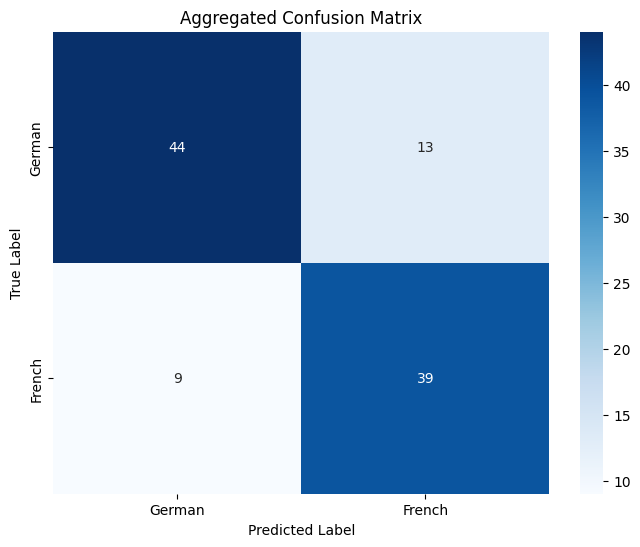

In [5]:
print("\nAggregated Confusion Matrix Across All Folds:")

if 'confusion_matrices' in results_aggregator and results_aggregator['confusion_matrices']:

    total_cm = np.sum(np.array(results_aggregator['confusion_matrices']), axis=0)

    class_labels = ['German', 'French']

    plt.figure(figsize=(8, 6))
    sns.heatmap(total_cm, annot=True, fmt='g', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Aggregated Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
else:
    print("No confusion matrix data available to plot.")

